# Betting markets - chart individual seat probabilities

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="#Plot-distribution-of-simple-overrounds" data-toc-modified-id="Plot-distribution-of-simple-overrounds-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot distribution of simple overrounds</a></span></li><li><span><a href="#Plot-seats" data-toc-modified-id="Plot-seats-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot seats</a></span><ul class="toc-item"><li><span><a href="#Plot" data-toc-modified-id="Plot-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Plot</a></span></li><li><span><a href="#Seats-that-look-like-a-close-contest" data-toc-modified-id="Seats-that-look-like-a-close-contest-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Seats that look like a close contest</a></span></li><li><span><a href="#Seats-where-Greens-most-competitve" data-toc-modified-id="Seats-where-Greens-most-competitve-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Seats where Greens most competitve</a></span></li><li><span><a href="#Seats-where-others-are-most-competitive" data-toc-modified-id="Seats-where-others-are-most-competitive-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Seats where others are most competitive</a></span></li></ul></li></ul></div>

## Python set-up

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import matplotlib.units as munits
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import common

# matplotlib stuff for date formatting xticklabels
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter
munits.registry[pd.Timestamp] = converter
munits.registry[pd.Period] = converter
plt.style.use('./markgraph.mplstyle')

/Users/bryanpalmer/miniforge3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Get data

In [2]:
FILE = '../historical-data/sportsbet-2022-individual-seats.csv'
df = pd.read_csv(FILE, na_values = 'SUS', parse_dates=['datetime'])
df = df[df['value'].notna()] # ignore missing values
len(df)

8298

In [3]:
df.columns

Index(['datetime', 'seat', 'variable', 'value'], dtype='object')

## Plot distribution of simple overrounds

In [4]:
overrounds = {}
for seat in df.seat.unique():
    overrounds[seat] = (
        df[df.seat == seat]
        .pivot(index='datetime', columns='variable', values='value')
        .iloc[-1]
        .pipe(lambda x: 1 / x)
        .sum()
    )
overround_series = pd.Series(overrounds)
overround_series

Banks (NSW)        1.152581
Barton (NSW)       1.147291
Bennelong (NSW)    1.139582
Berowra (NSW)      1.131437
Blaxland (NSW)     1.133635
                     ...   
Bean (ACT)         1.178751
Canberra (ACT)     1.178496
Lingiari (NT)      1.145667
Solomon (NT)       1.147346
Tangney (WA)       1.149682
Length: 151, dtype: float64

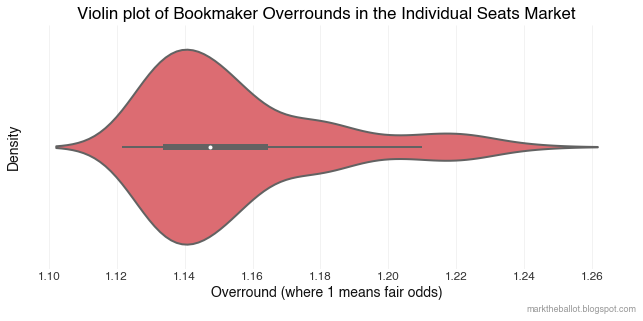

In [5]:
overround_series.index = range(len(overround_series))
ax = sns.violinplot(x=overround_series,
               orient='h')
title = 'Violin plot of Bookmaker Overrounds in the Individual Seats Market'
common.plot_finalise(ax, title=title, 
                     ylabel='Density', 
                     xlabel='Overround (where 1 means fair odds)')

## Plot seats

In [6]:
def colourise(s:str) -> str:
    colors = {
        'coalition': 'navy',
        'labor':     '#cc0000',
        'green':     'darkgreen',
        'independent': 'darkorange',
        'one nation': 'darkorchid',
        'jacqui lambie network': 'dodgerblue'
    }
    for party in colors.keys():
        if party in s.lower():
            return colors[party]
    return 'hotpink'

def plot_seat(df:pd.DataFrame, seat:str) -> float:

    # get seat probabilities
    IGNORE_ODDS_ABOVE = 25 # dollars - minimise impact of the longshot bias
    seat_probs = (
        df[df.seat == seat]
        .pivot(index='datetime', columns='variable', values='value')
        .sort_index(ascending=True)
        
        # Favourite-Longshot Bias management
        # NOTE: change method statement at the end of this statement
        #.pipe(lambda x: x.where(x <= IGNORE_ODDS_ABOVE, other=np.nan)) 
        #.pipe(lambda x: x * x) 
        .pipe(lambda x: x * np.sqrt(x)) 

        .dropna(how='all', axis=1)
        .pipe(lambda x: 1 / x)
        .pipe(lambda x: x.div(other=x.sum(axis=1), axis=0))
    ) * 100 # per cent
    #flb_method = f'Favourite-Longshot Bias management: odds > ${IGNORE_ODDS_ABOVE} removed'
    #flb_method = 'Favourite-Longshot Bias management: odds-squared'
    #flb_method = 'Favourite-Longshot Bias management: none'
    flb_method = 'Favourite-Longshot Bias management: raw-odds * sqrt(raw-odds)'
    
    # capture some additional statistics
    latest = seat_probs.iloc[-1]
    latest_best = latest.max()
    green_prob = None if 'Green' not in latest.index else latest['Green']
    majors = ['Coalition', 'Liberal', 'Labor', 'Green']
    other_prob = latest[[x for x in latest.index if x not in majors]].sum()

    # plot
    markers = ['p', '+', 'D', 'o', 's', 'v', '^', ]
    fig, ax = plt.subplots()
    for i, column in enumerate(seat_probs.columns):
        c = colourise(column)
        m = markers[i]
        ax.plot(seat_probs.index, seat_probs[column], 
                markersize=6,
                lw=2, color=c, marker=m, label=column)
    ax.axhline(50, color='#999999', lw=0.5)
    ax.legend(loc='center left', prop={'size': 9}, ncol=2)
    title = f'Sportsbet seat win probabilities over time - {seat}'
    common.plot_finalise(ax, title=title, ylabel='Implied Win Probability (%)',
                         lfooter=flb_method, save_suffix=flb_method)
    
    # return additional statistics
    return latest_best, green_prob, other_prob

### Plot

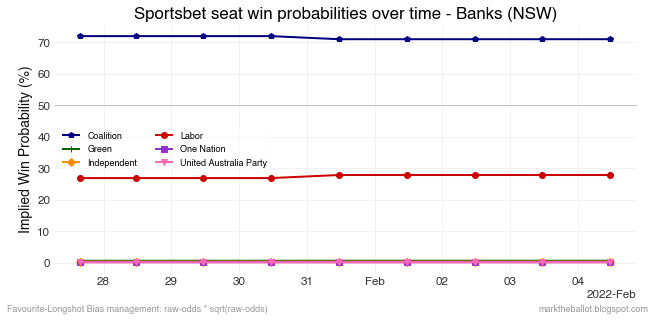

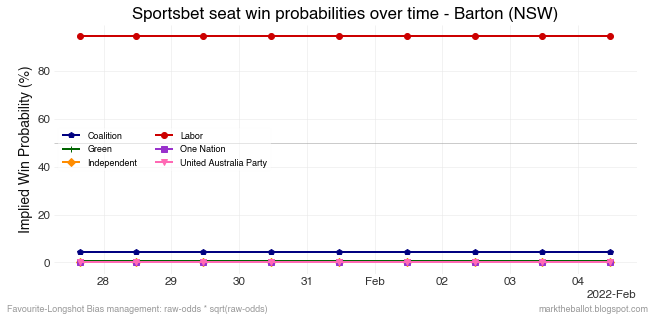

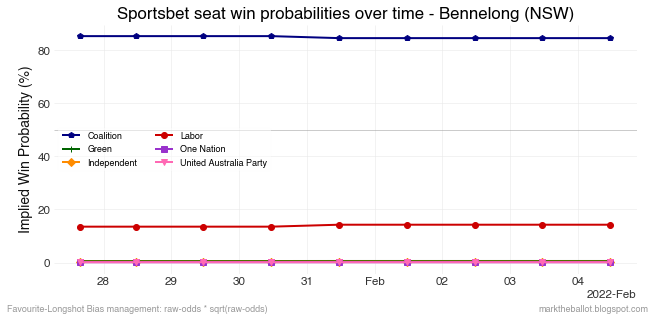

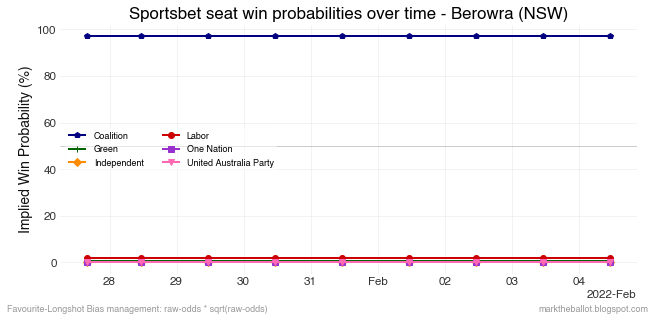

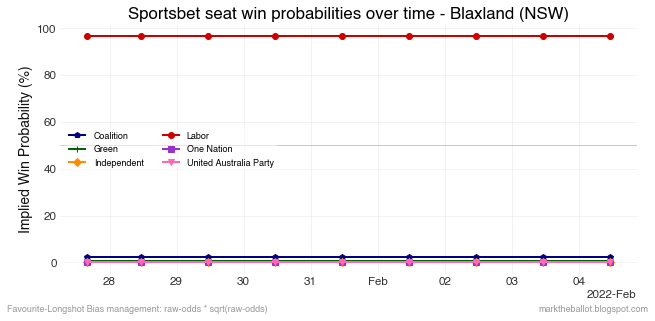

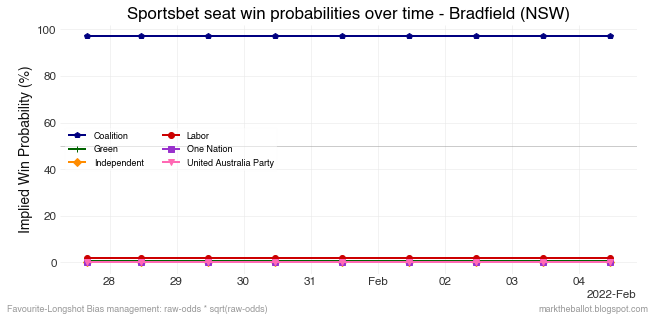

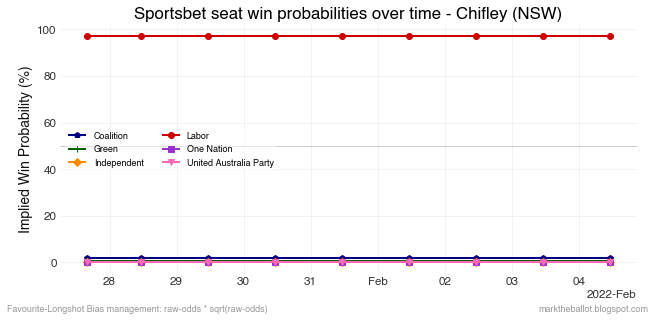

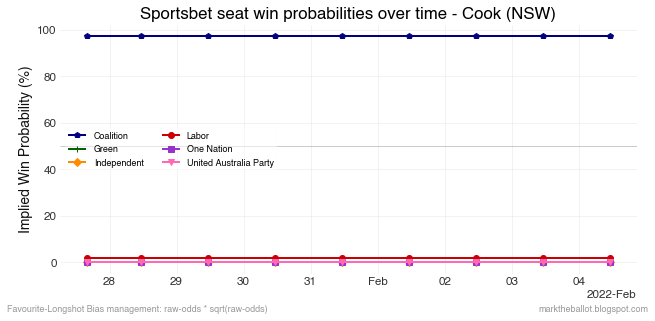

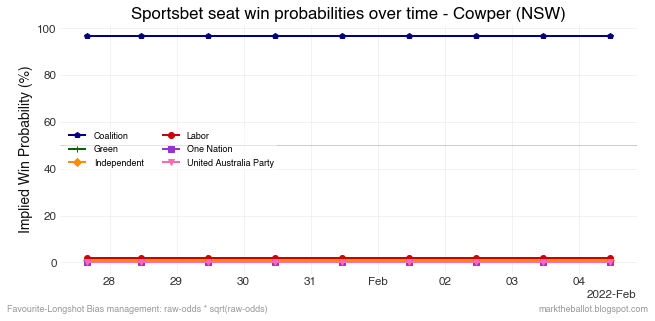

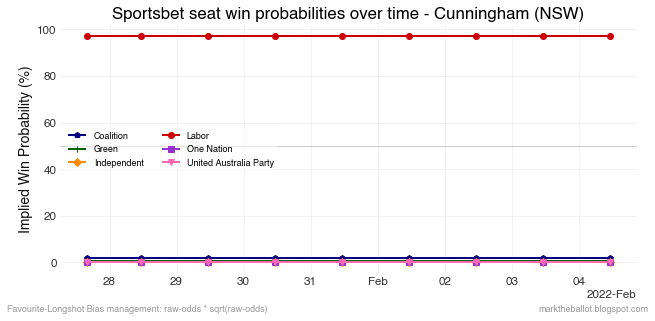

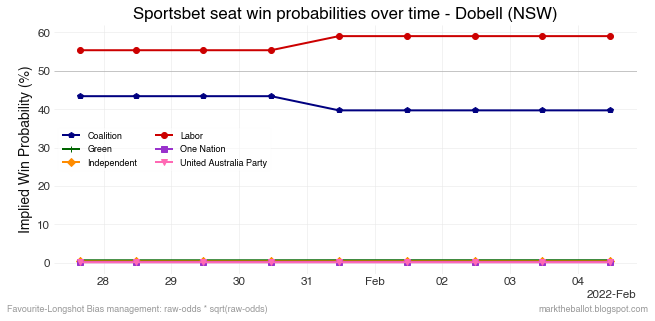

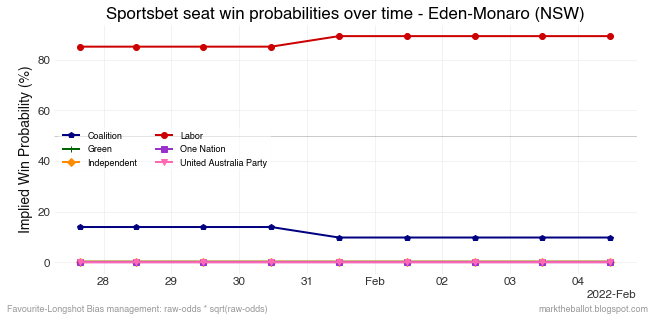

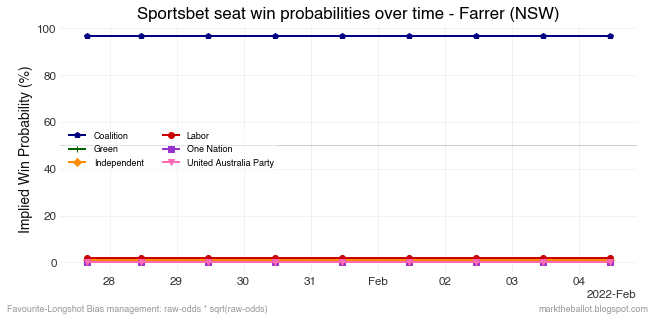

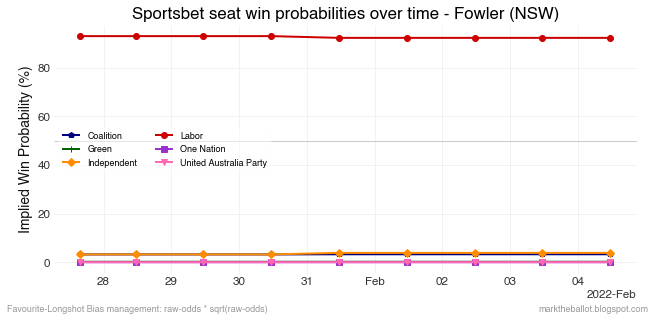

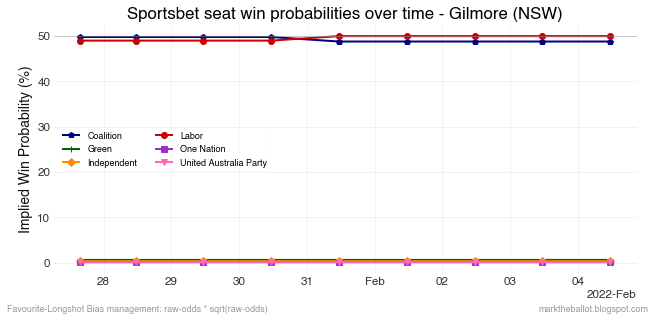

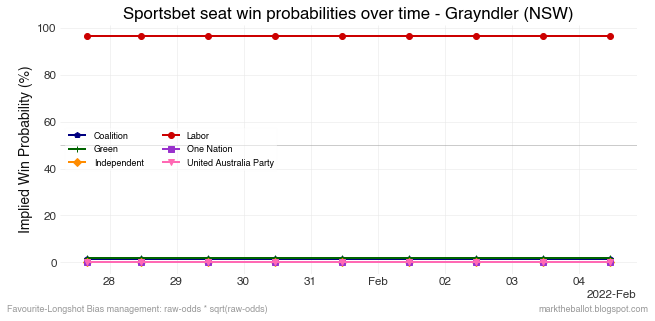

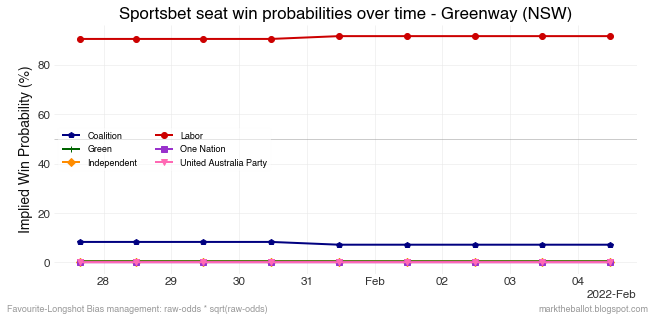

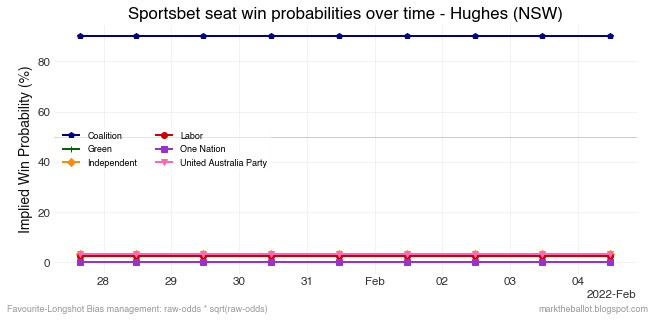

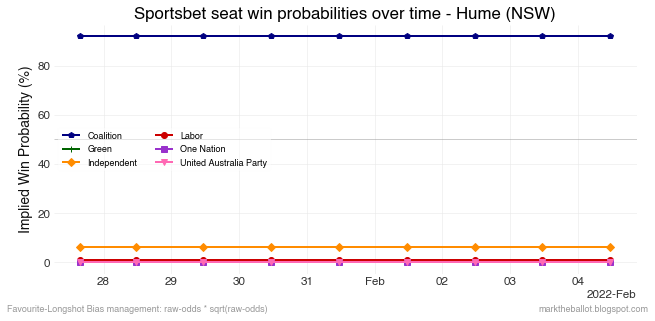

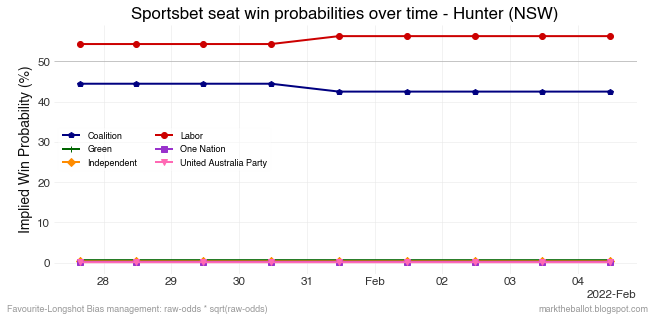

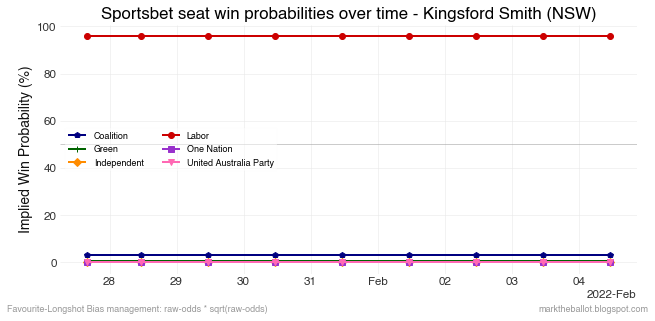

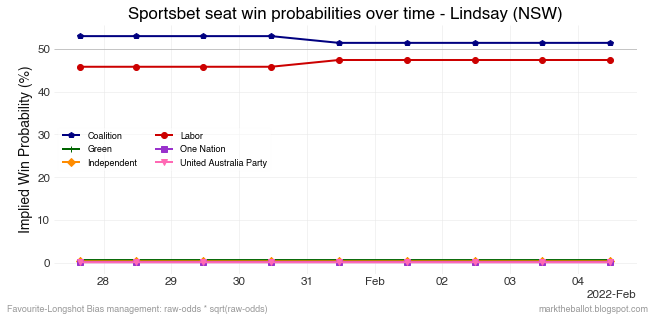

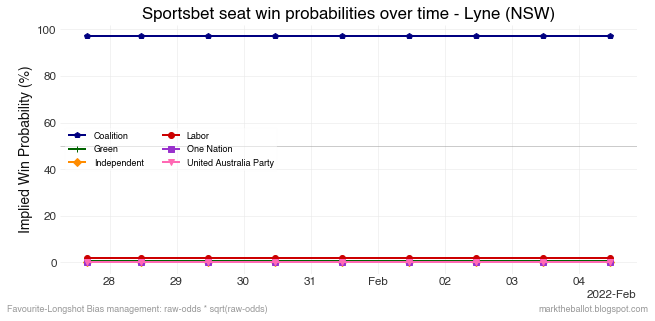

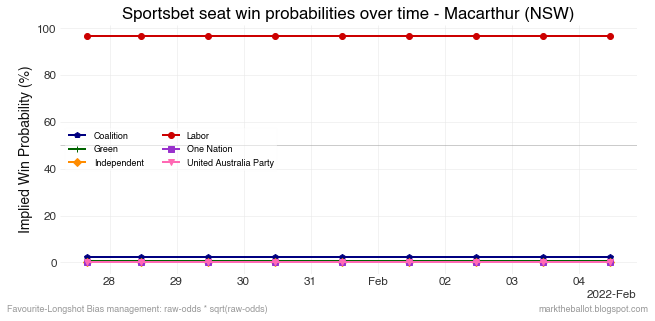

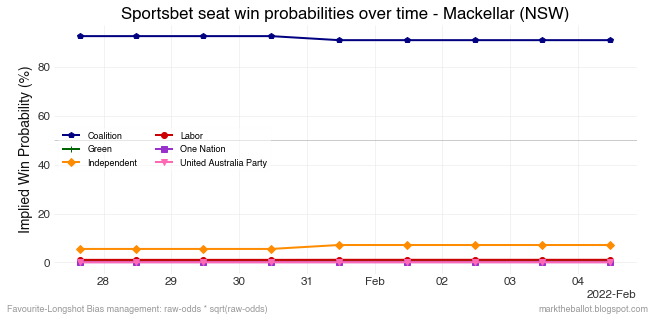

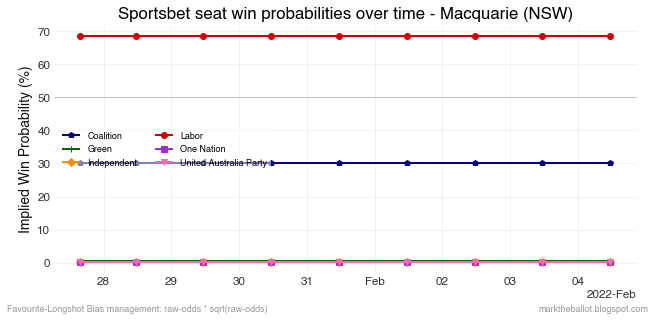

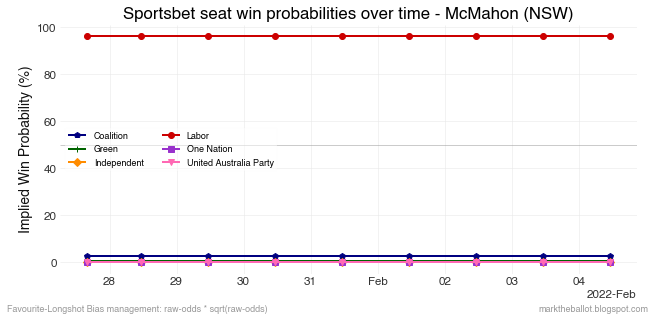

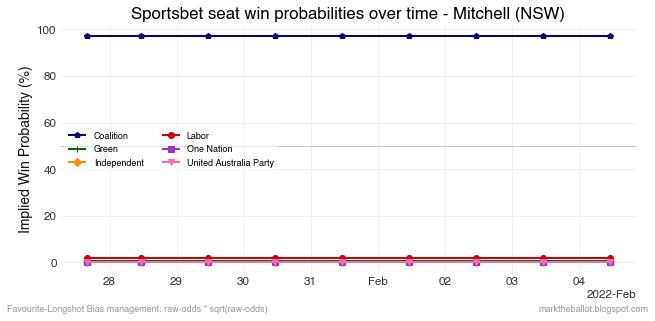

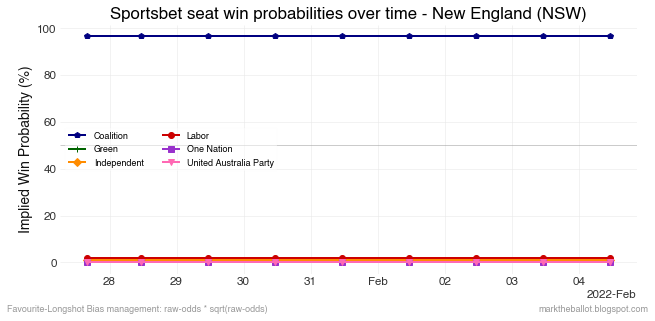

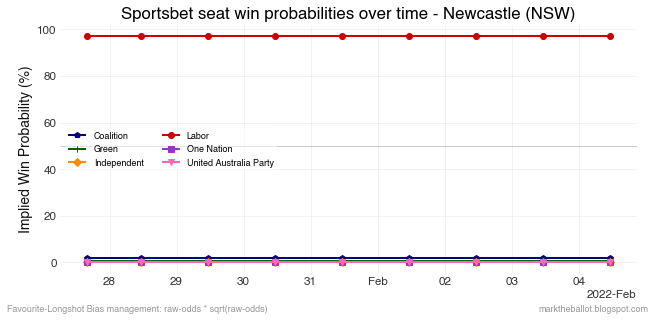

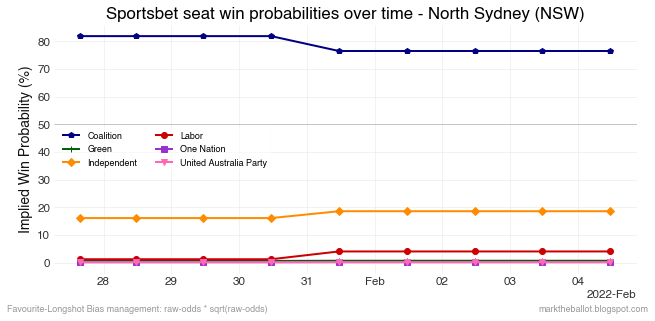

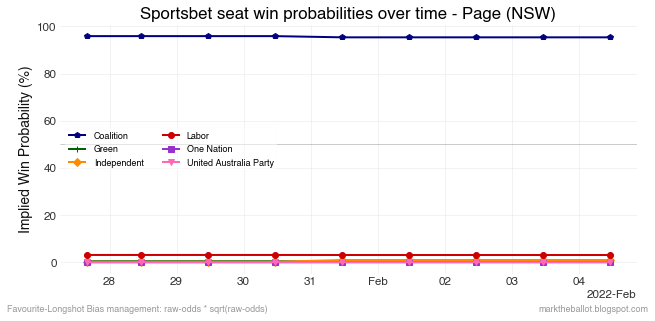

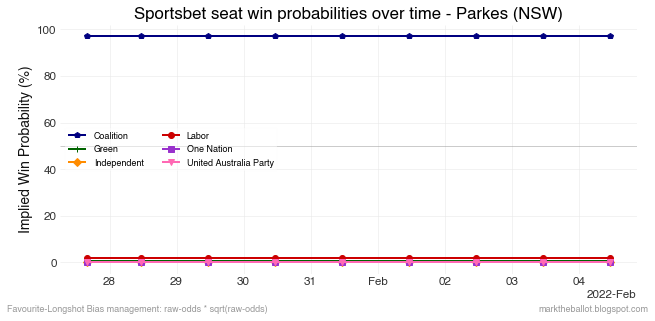

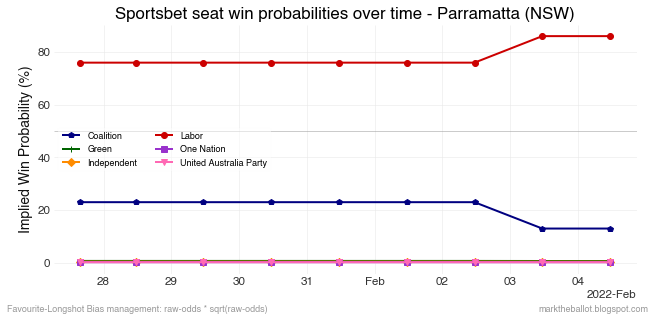

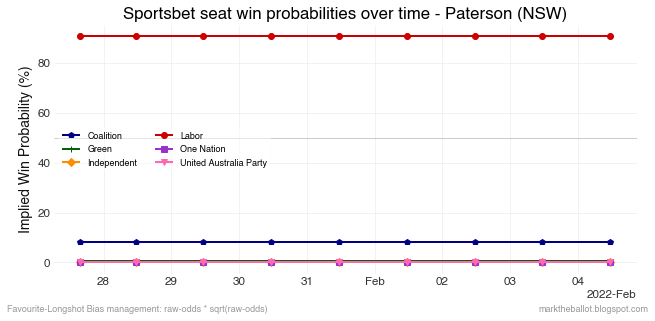

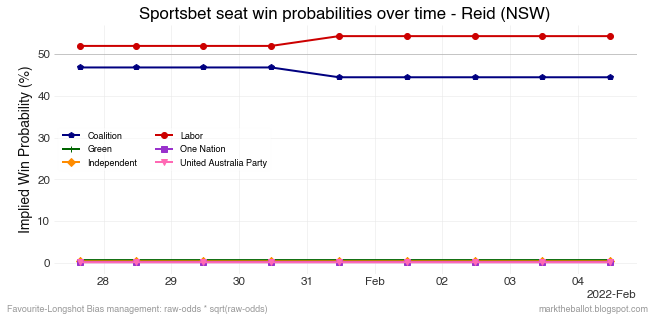

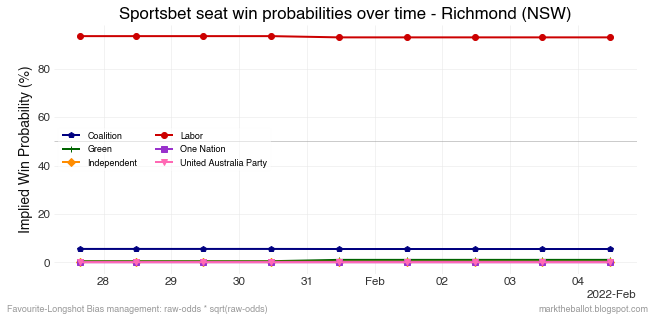

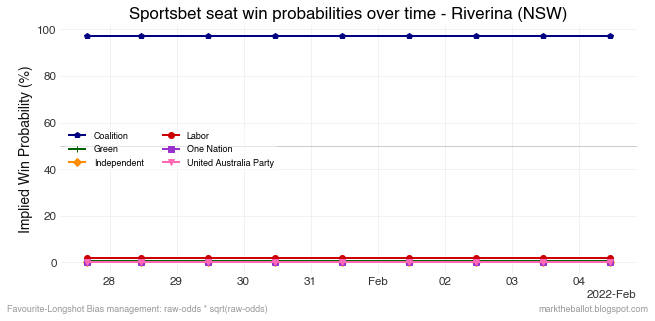

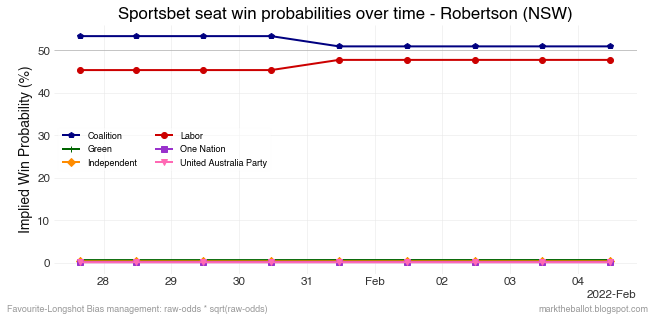

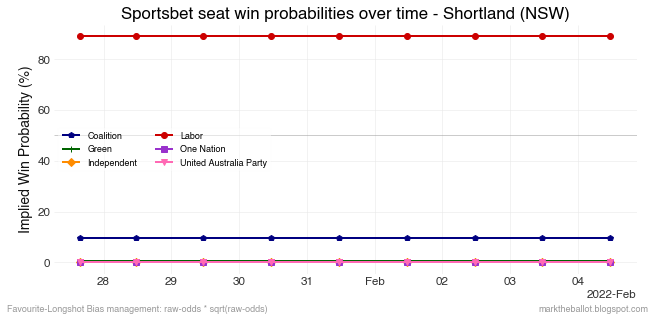

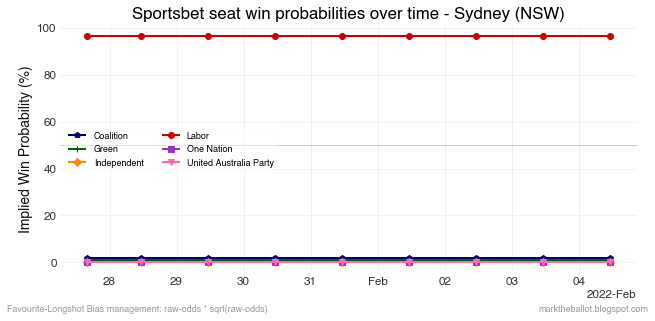

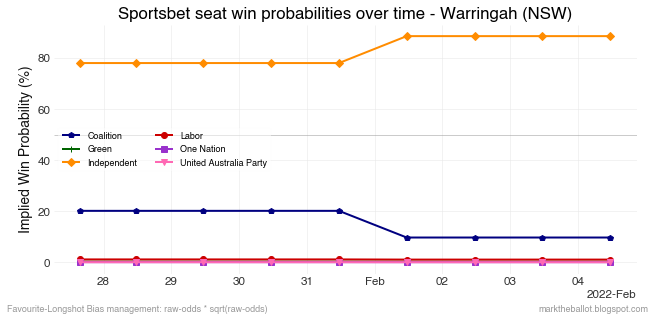

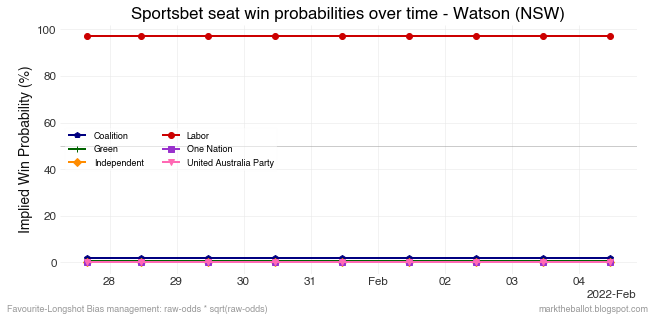

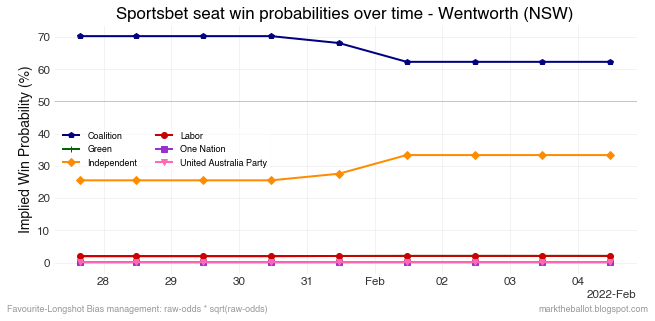

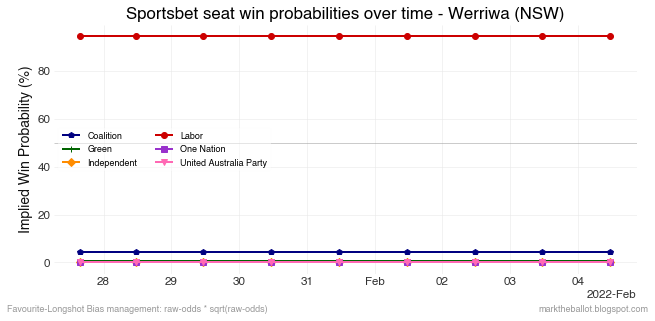

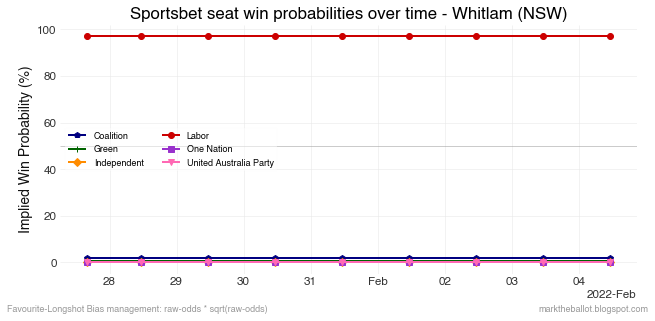

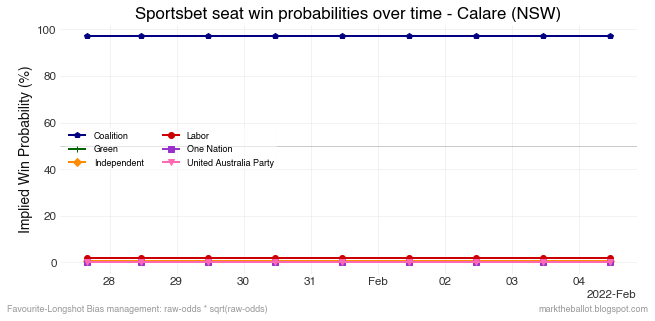

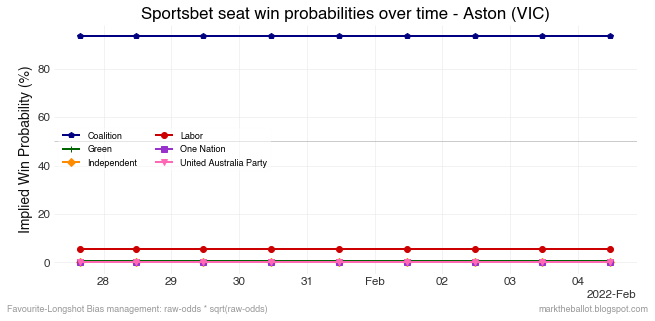

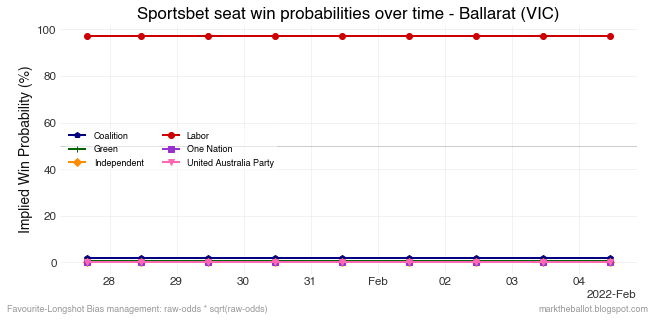

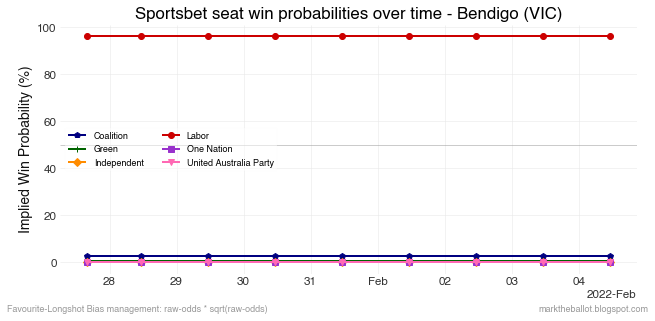

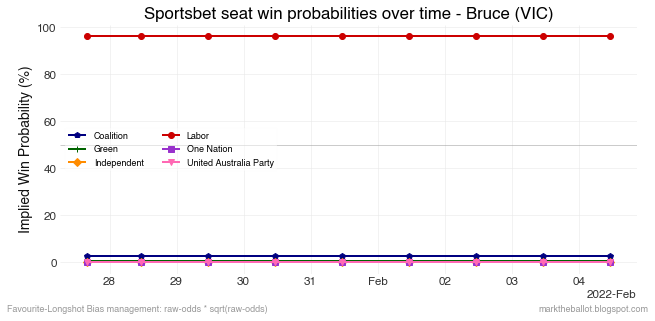

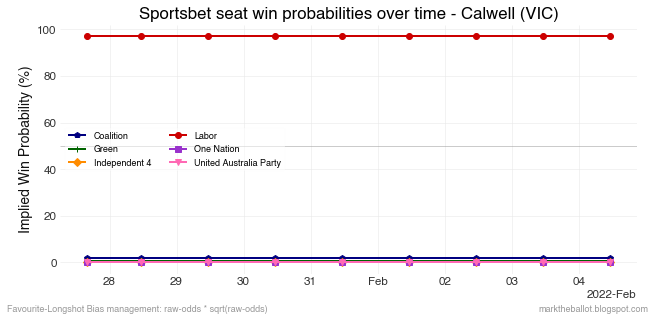

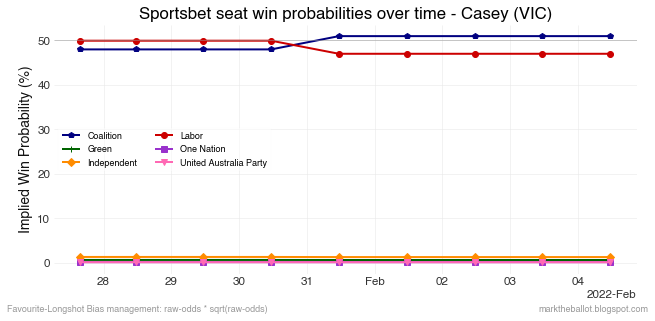

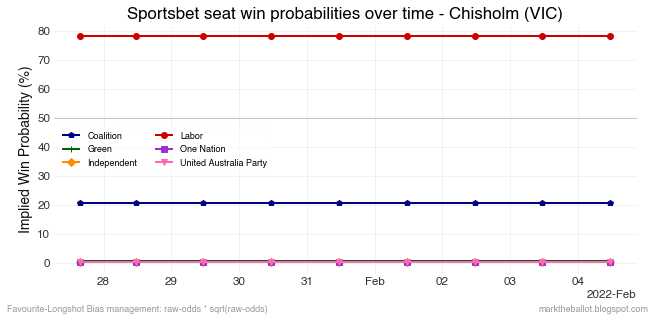

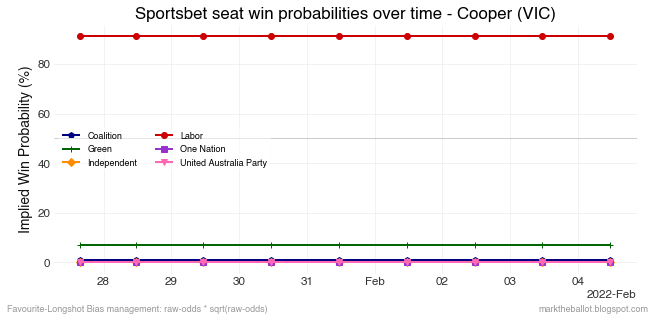

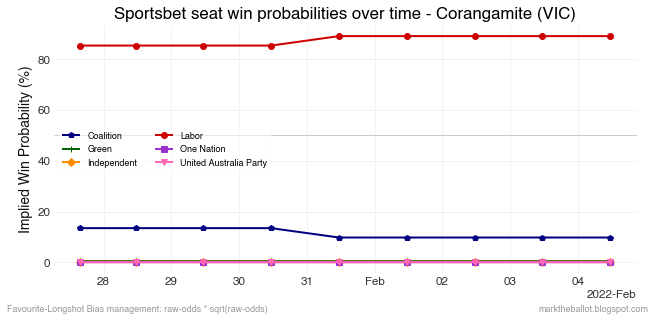

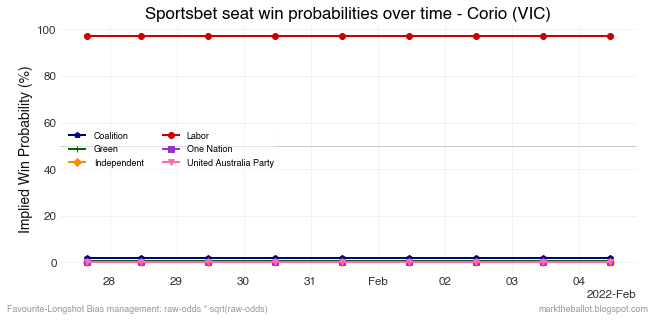

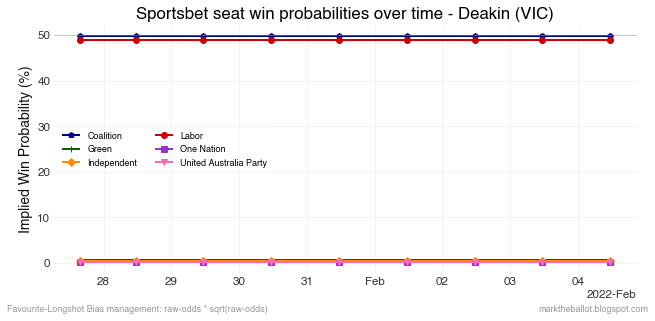

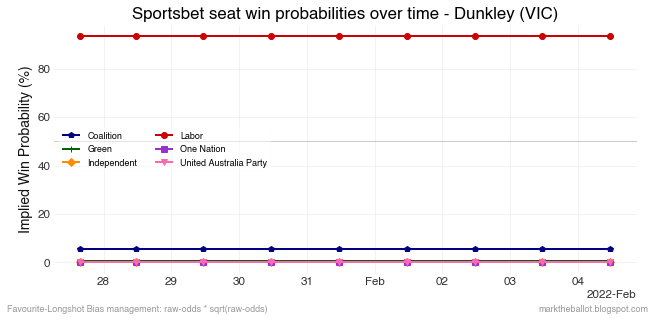

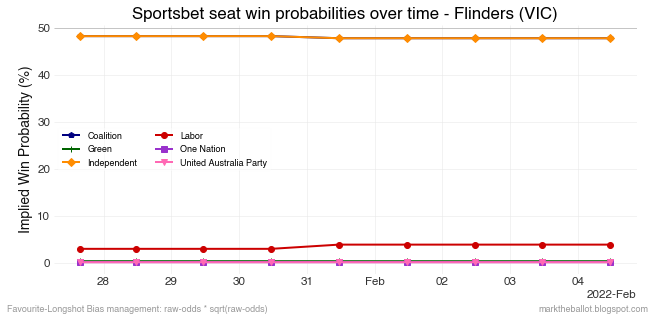

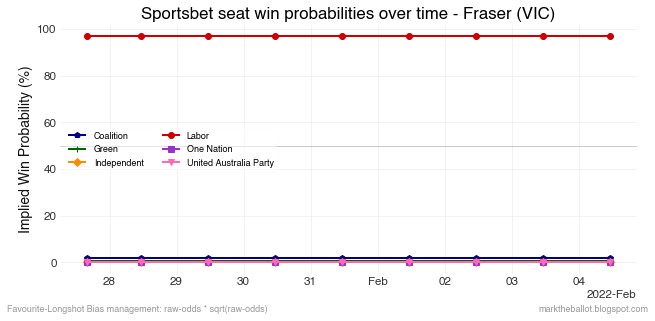

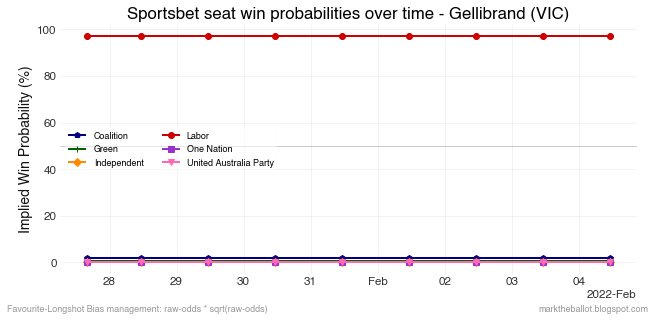

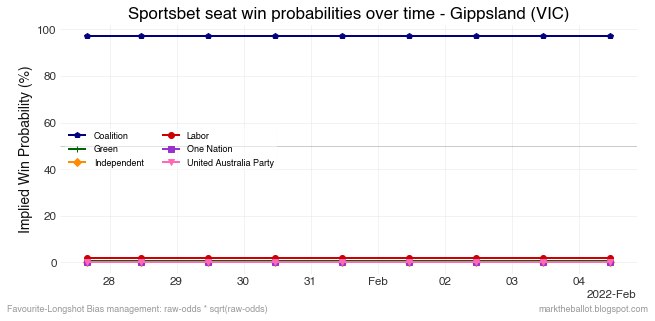

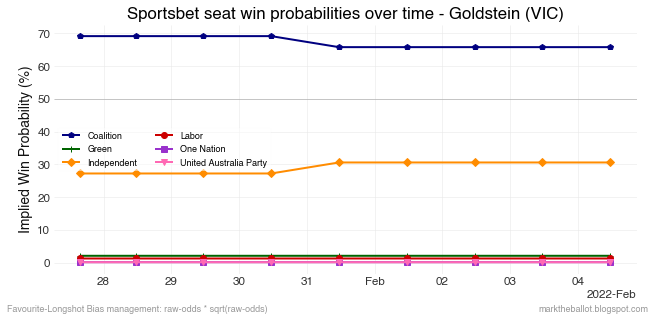

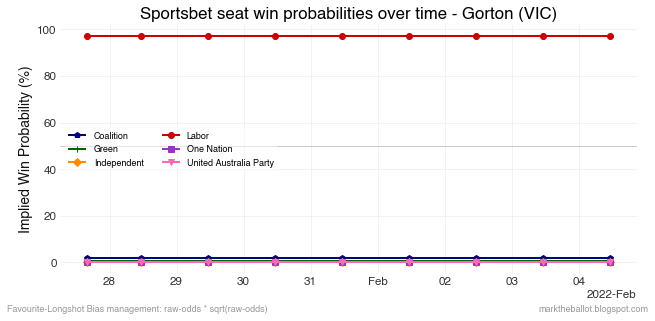

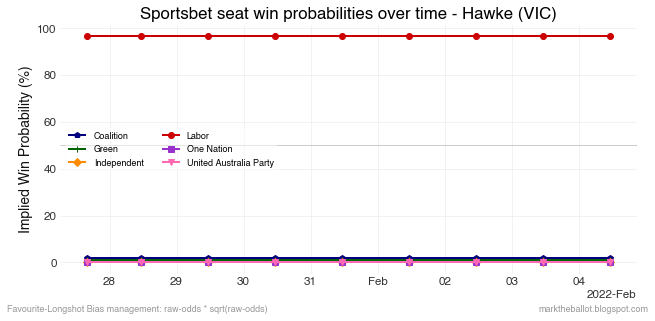

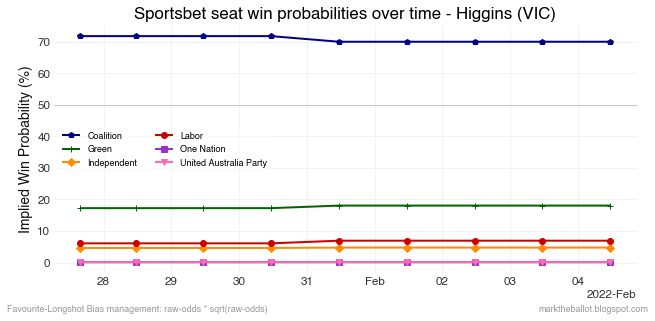

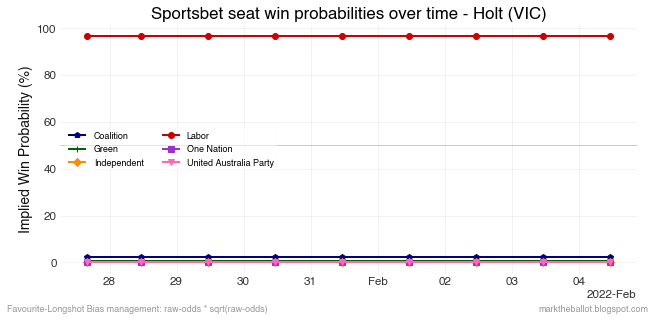

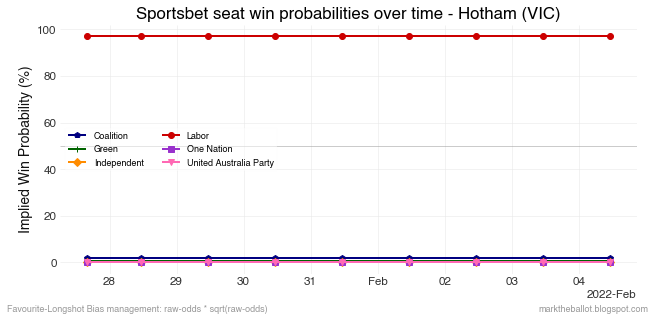

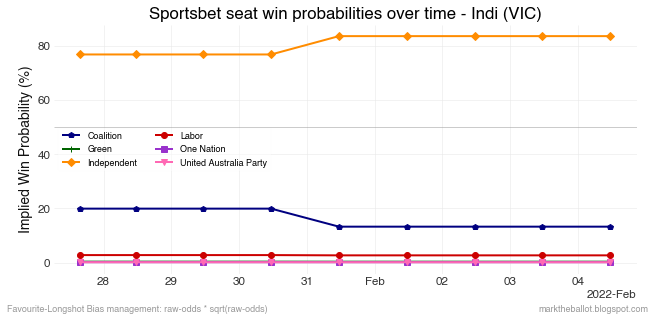

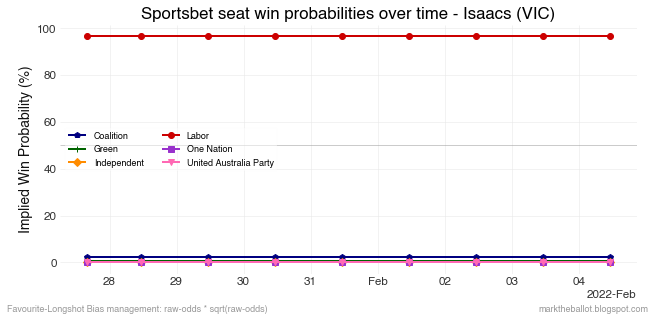

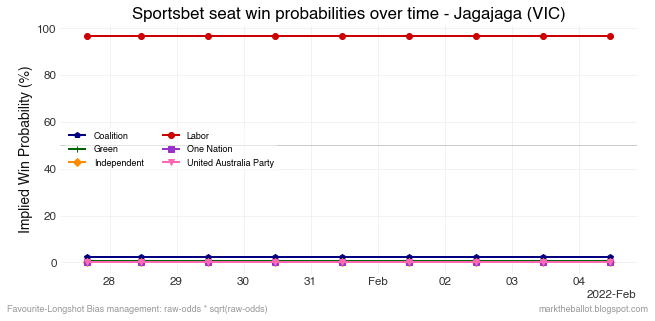

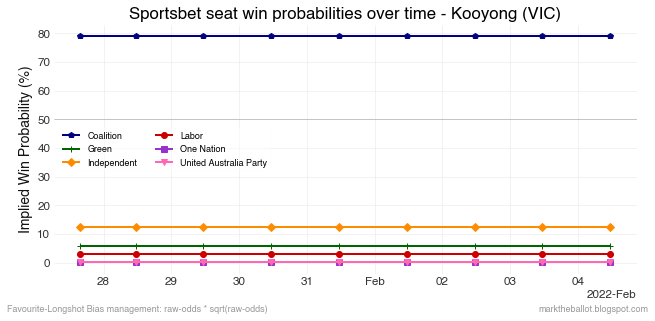

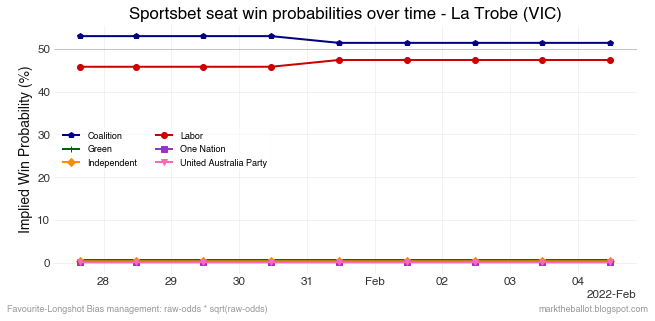

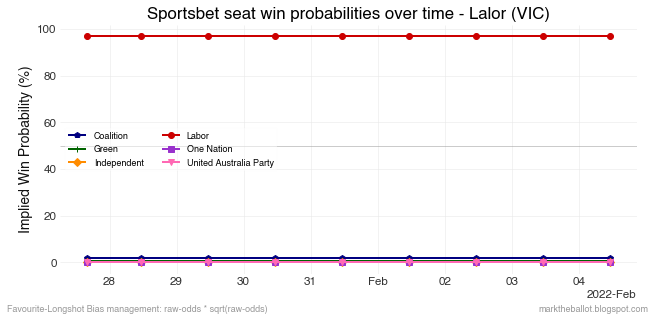

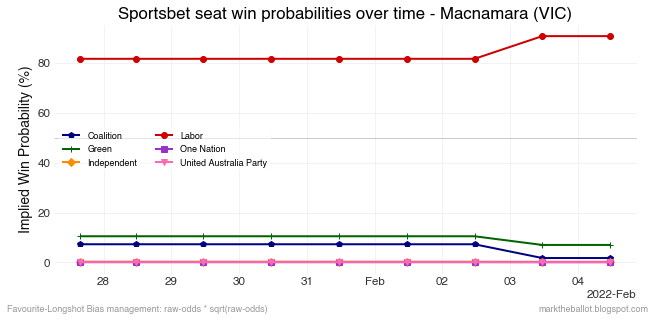

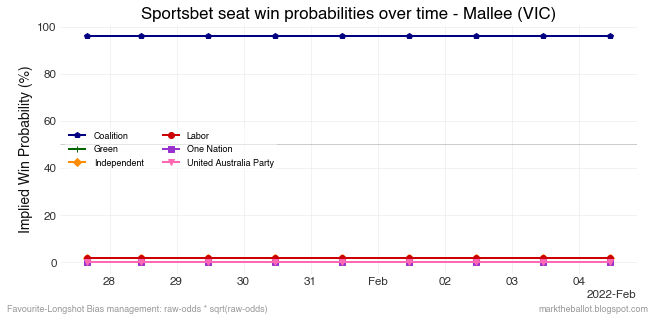

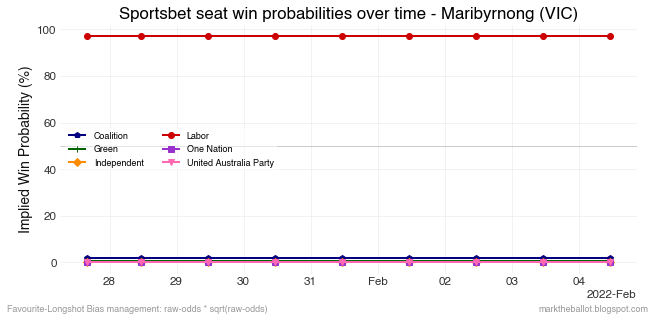

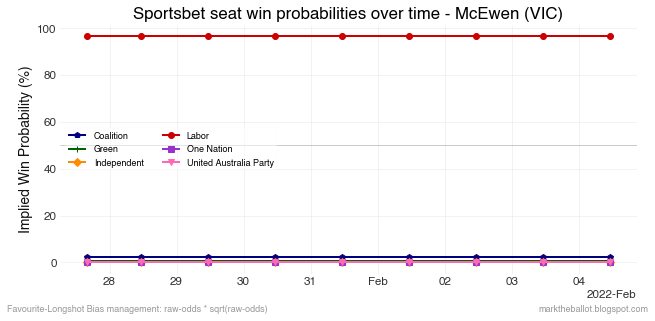

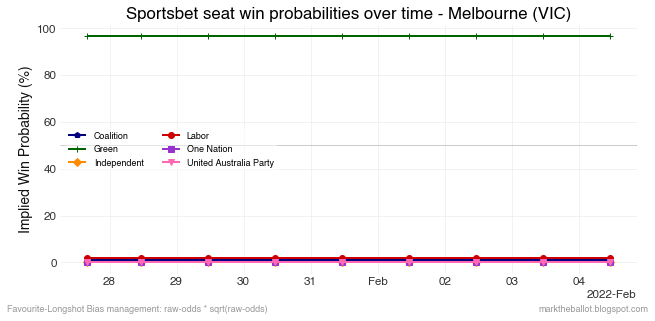

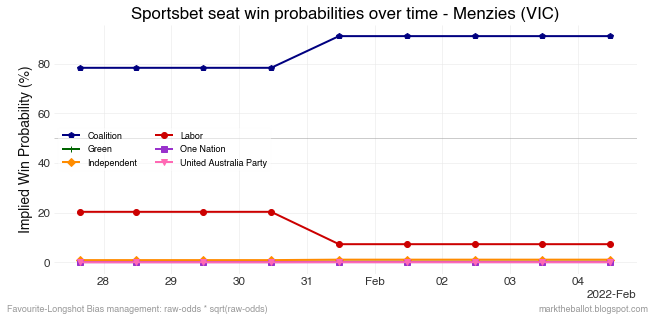

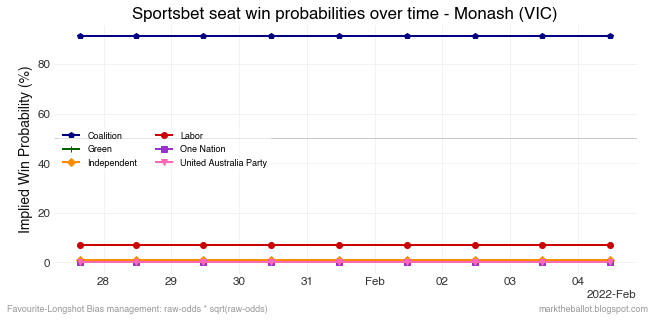

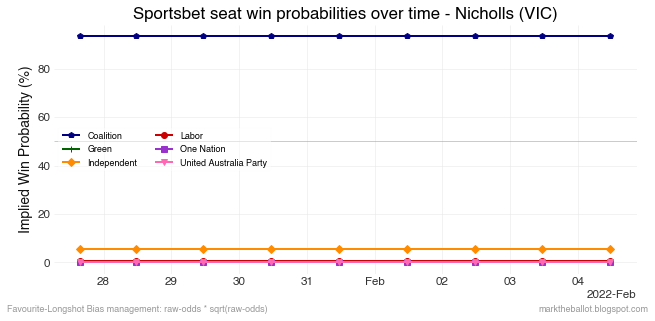

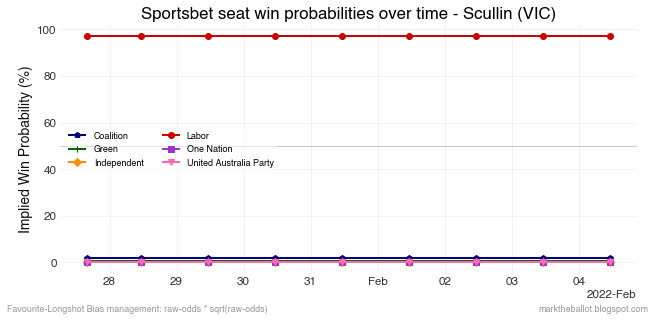

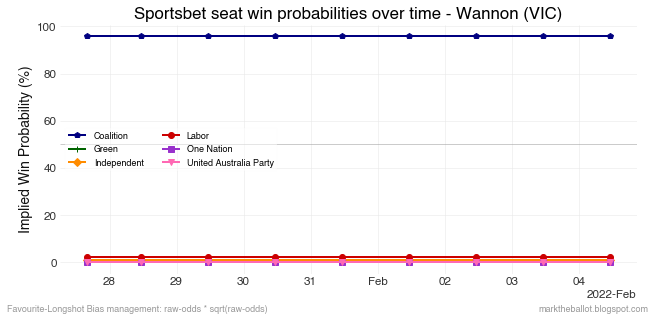

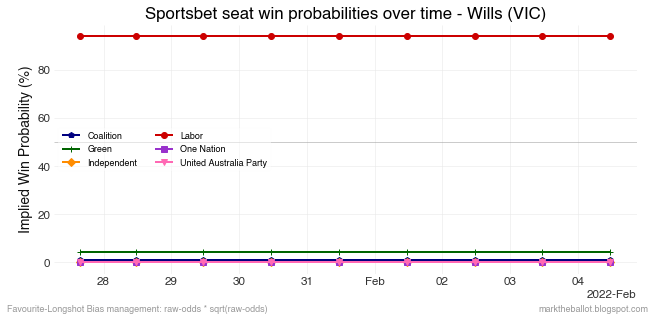

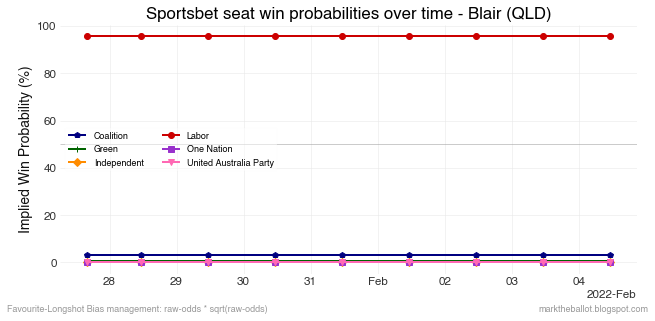

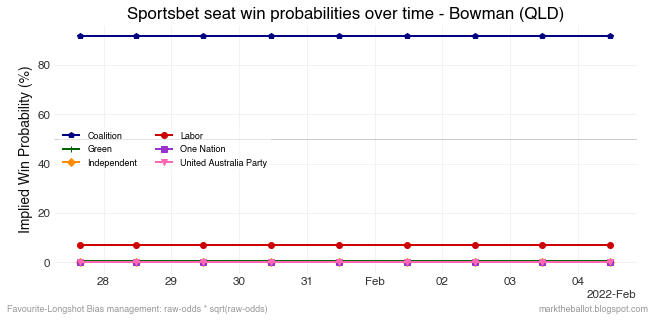

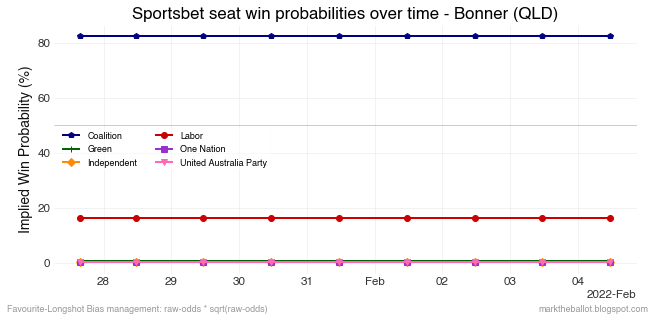

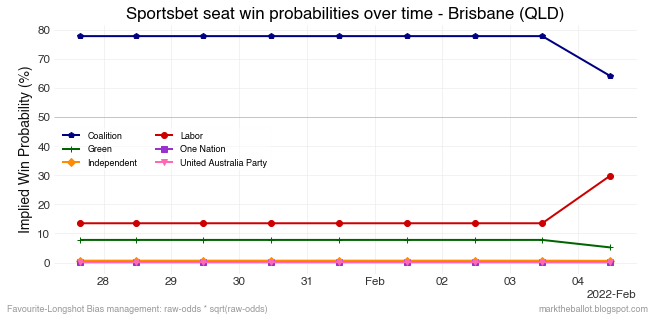

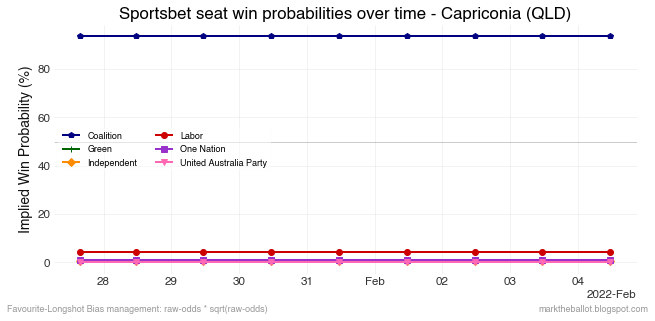

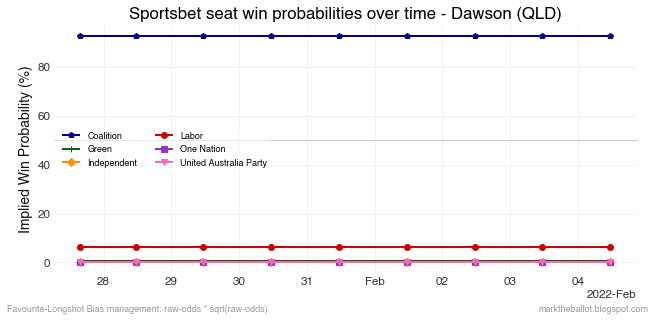

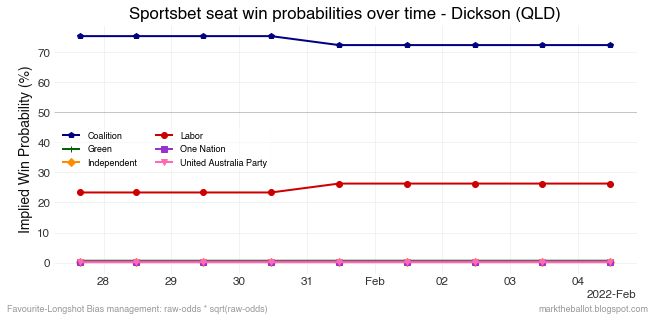

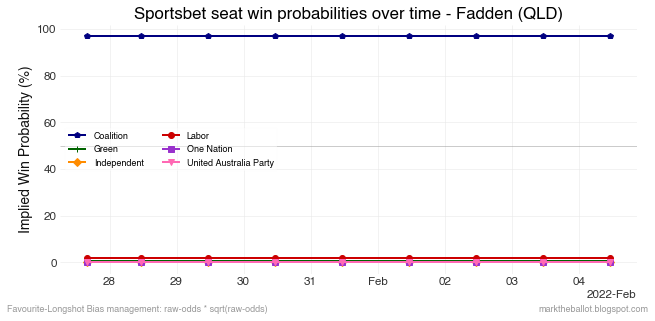

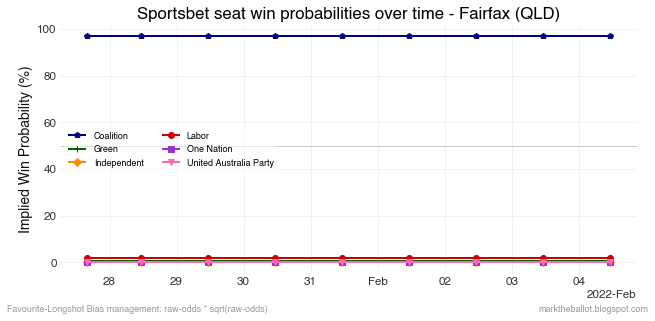

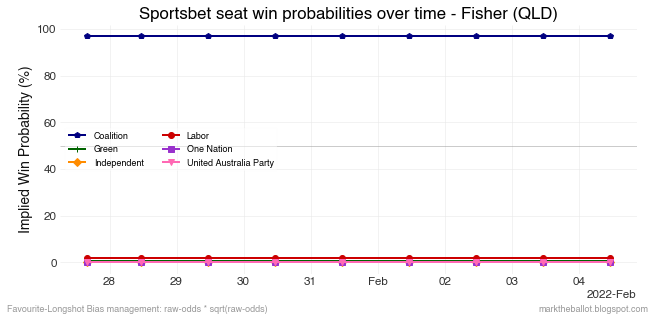

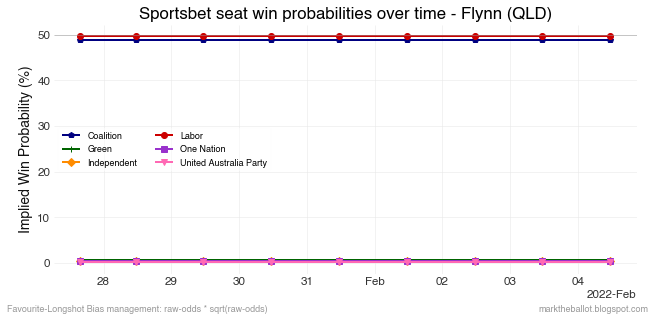

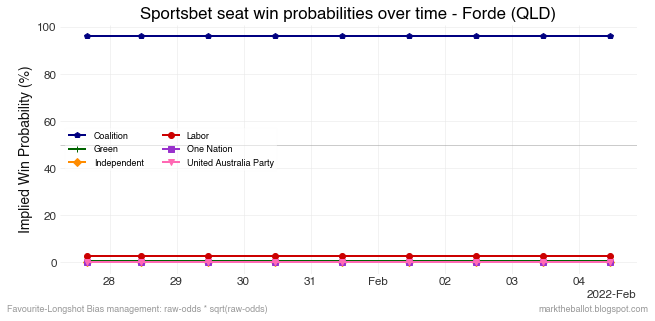

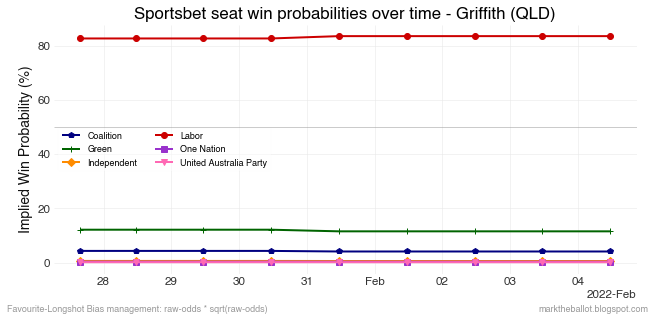

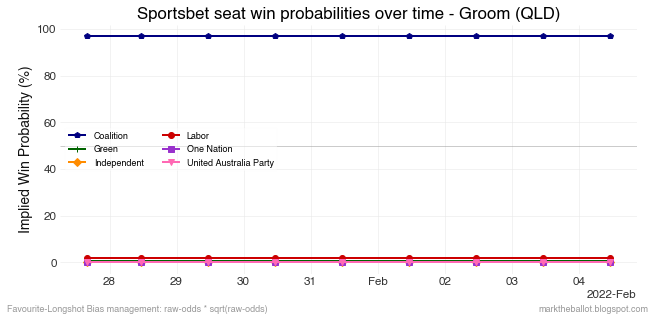

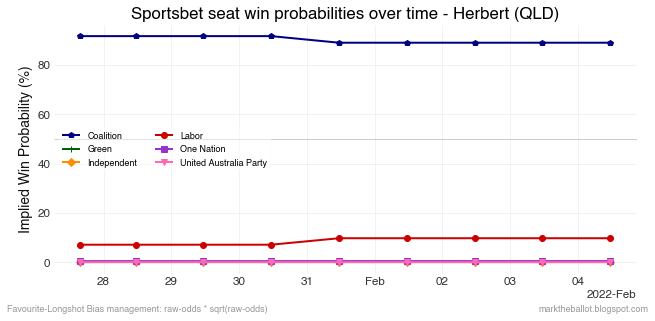

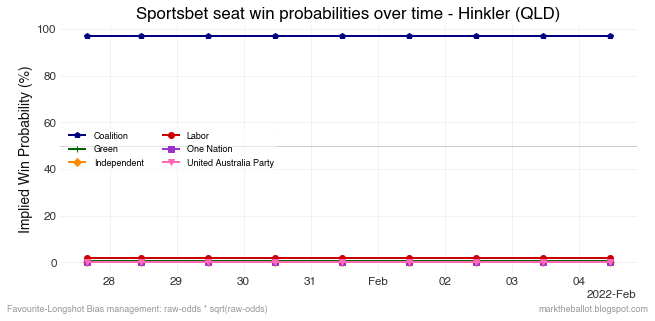

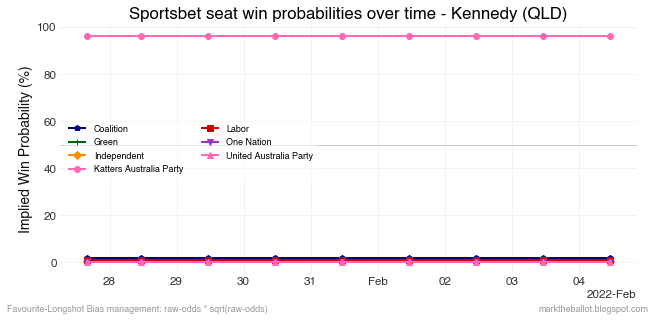

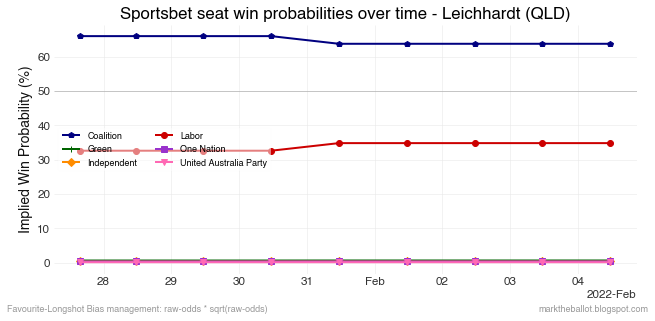

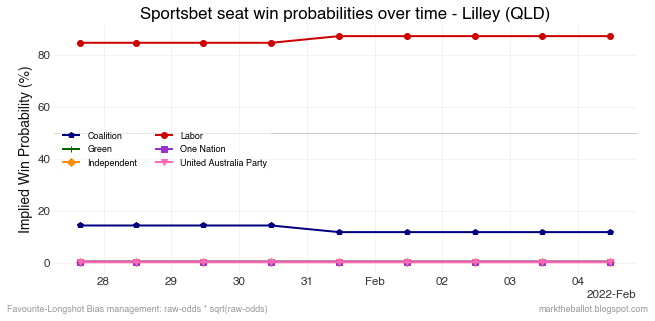

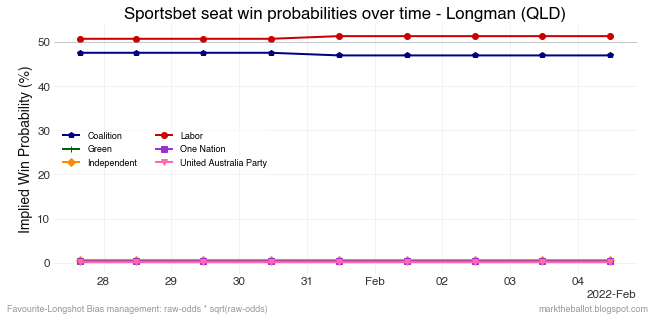

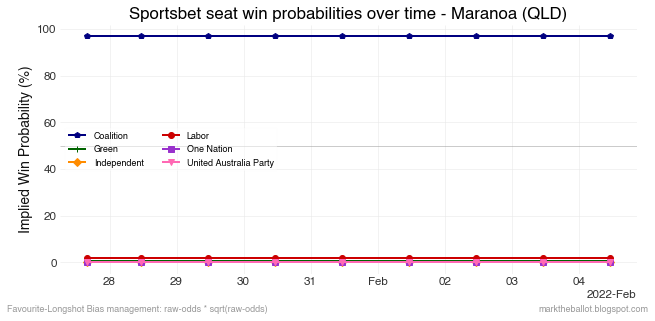

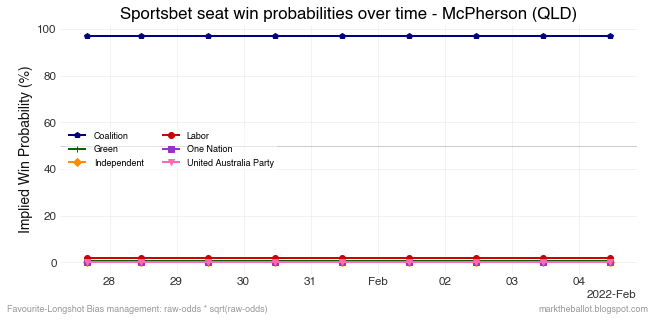

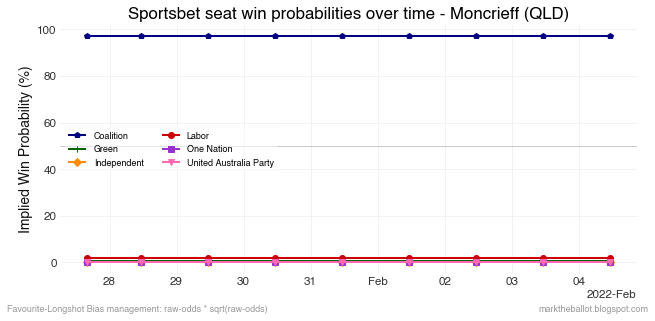

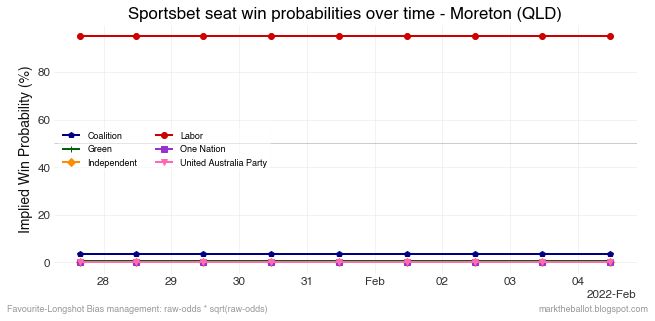

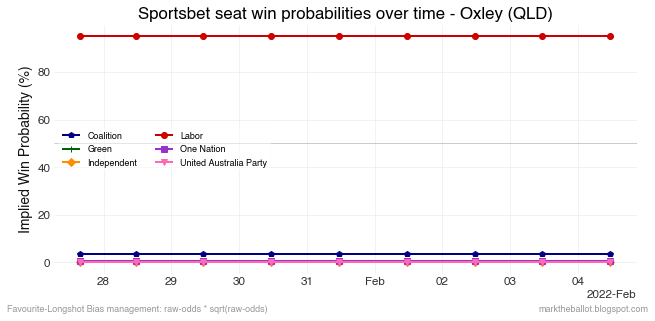

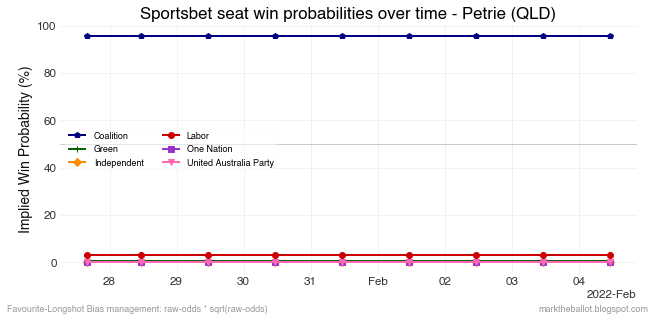

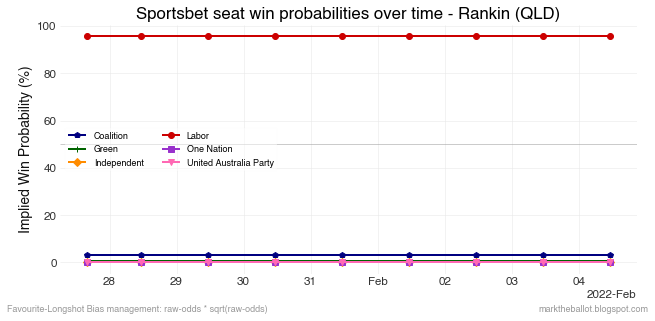

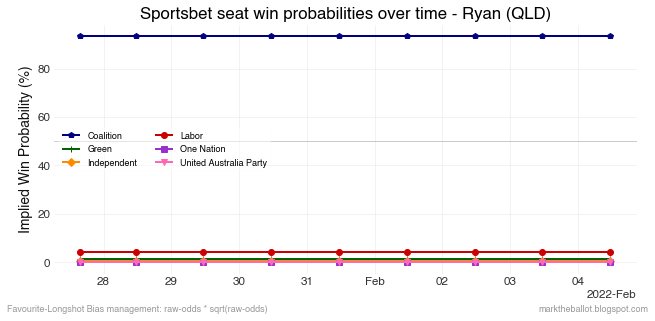

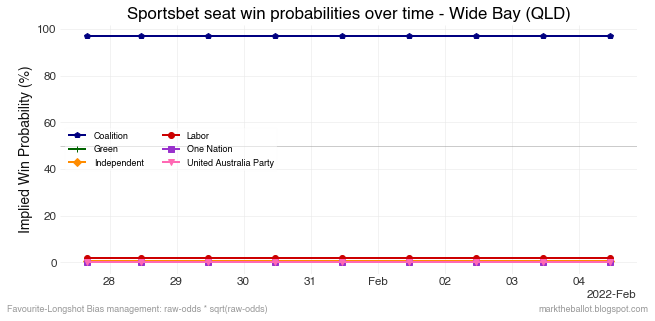

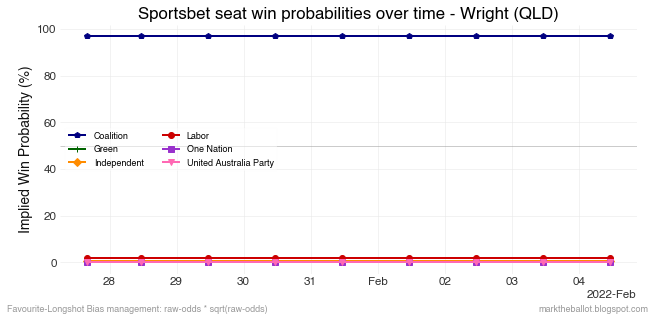

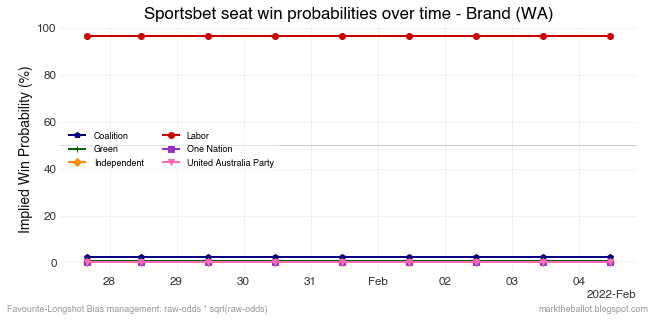

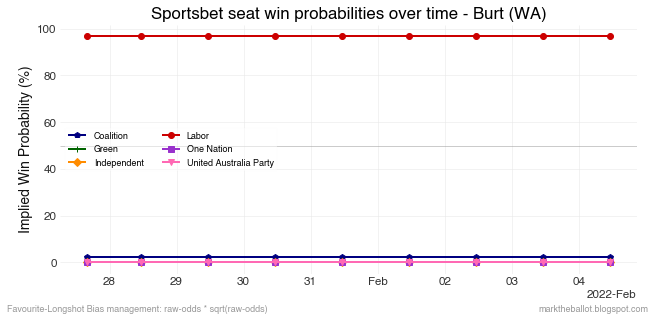

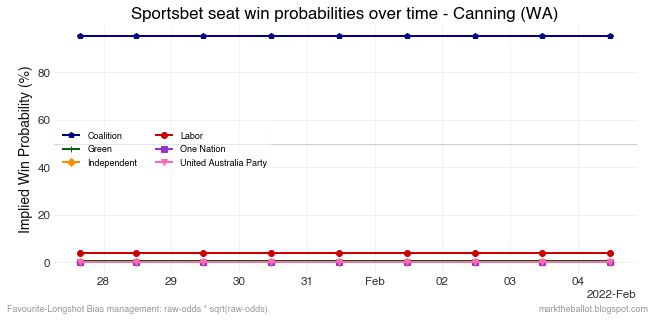

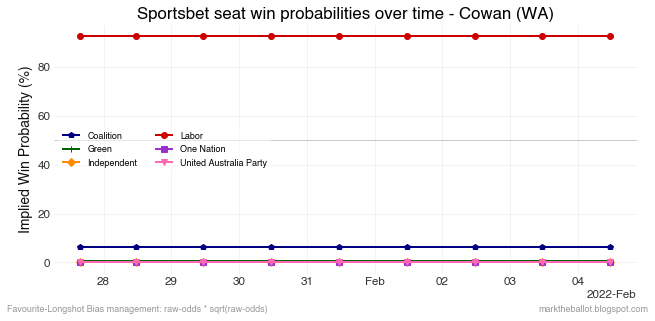

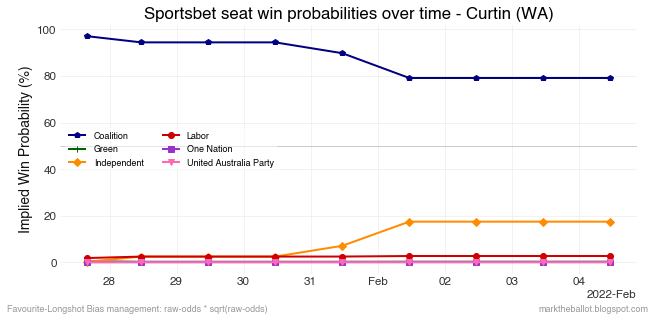

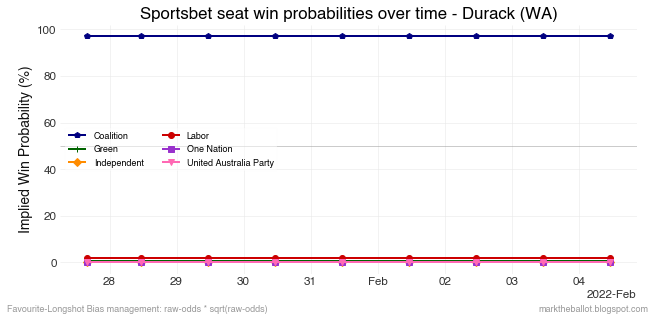

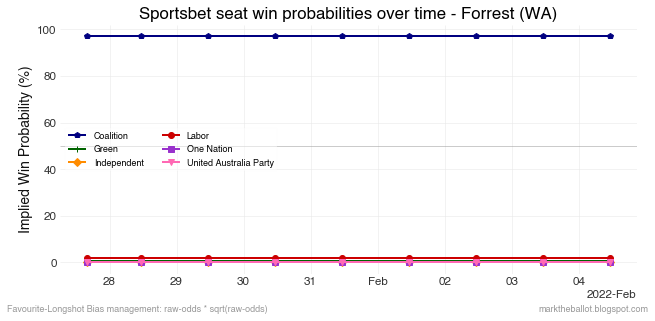

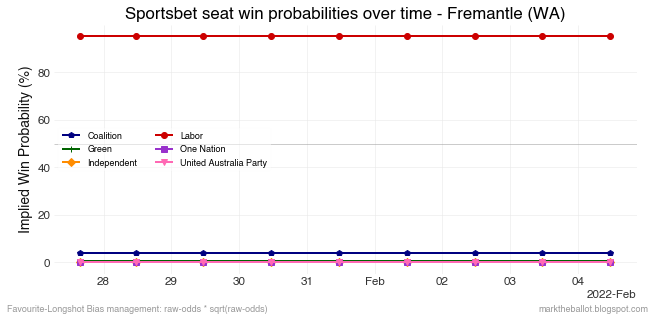

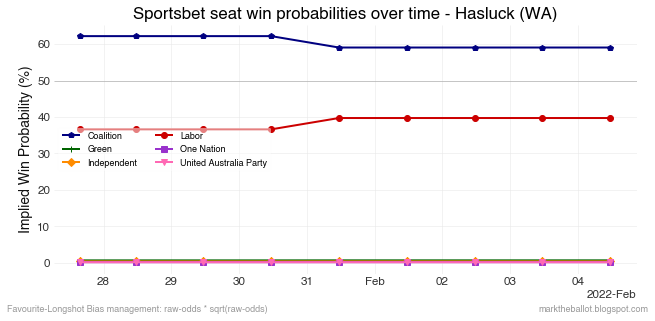

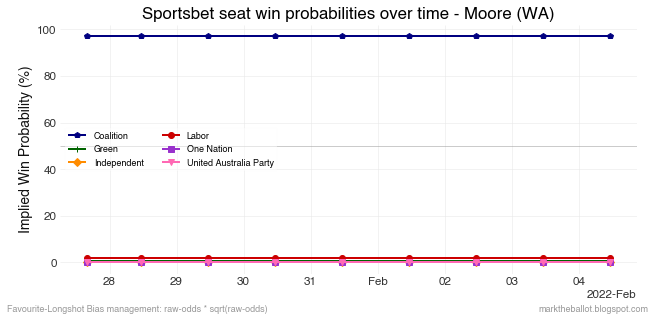

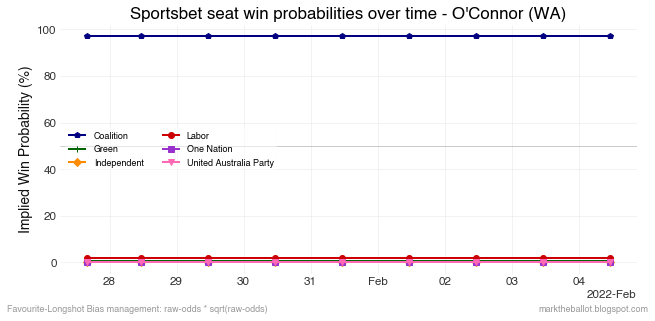

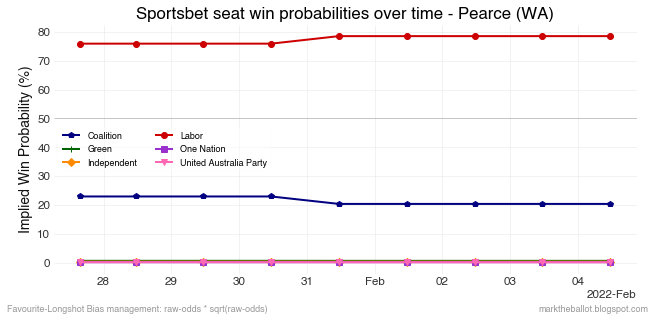

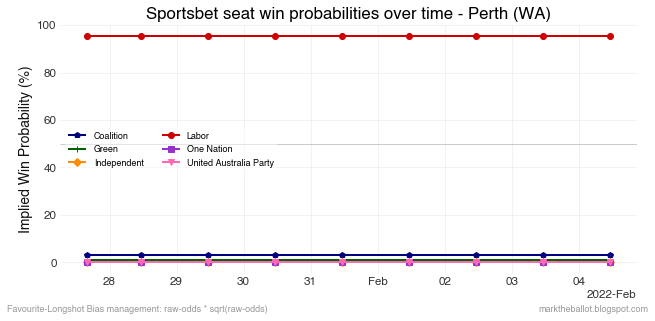

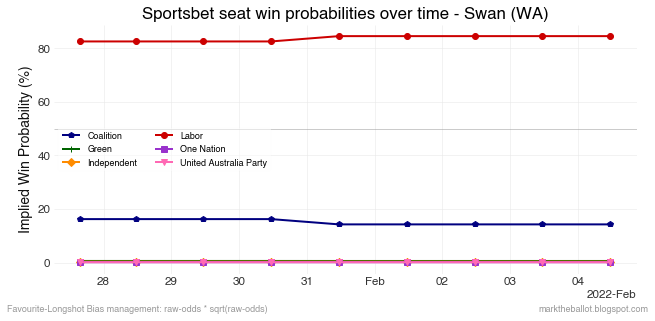

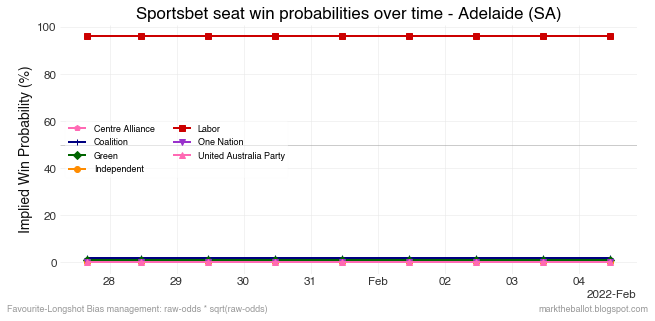

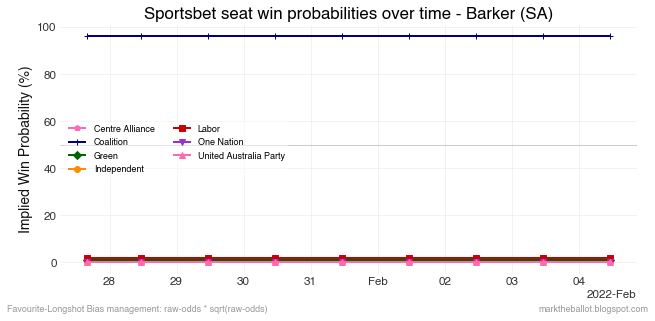

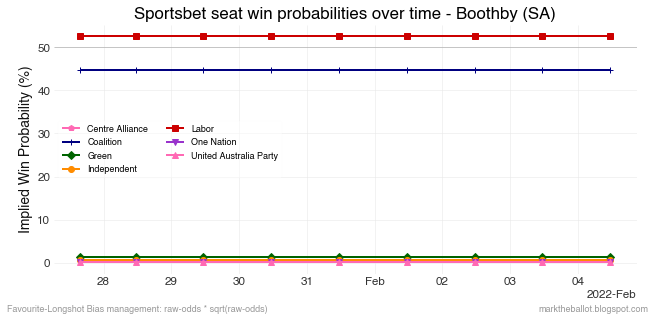

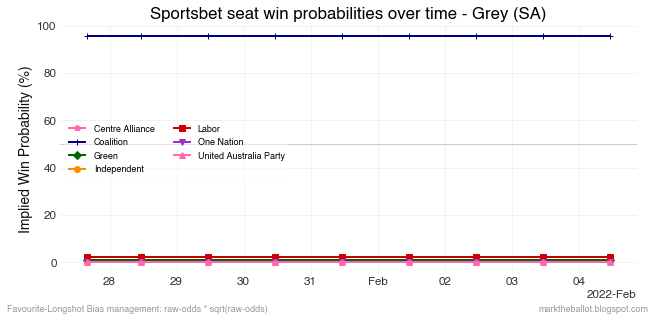

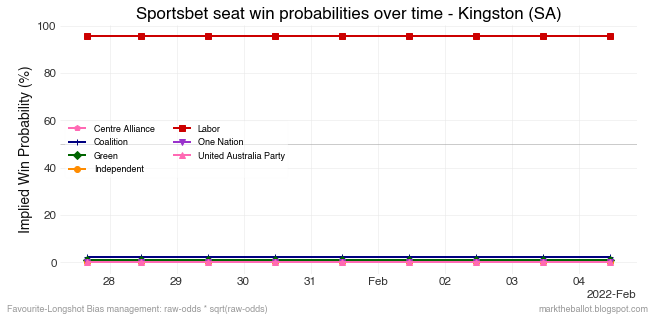

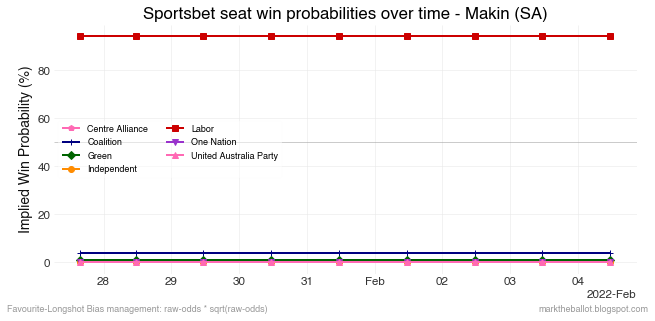

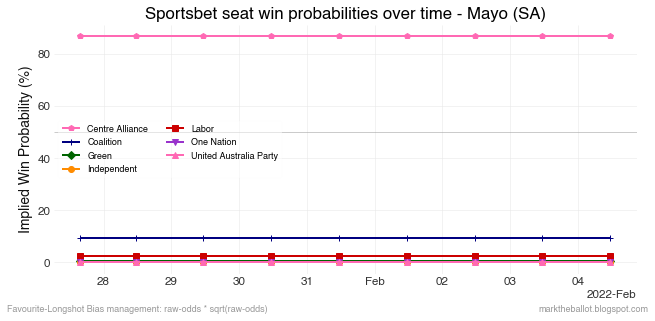

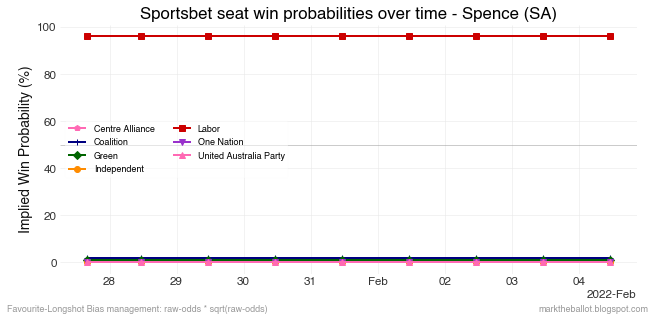

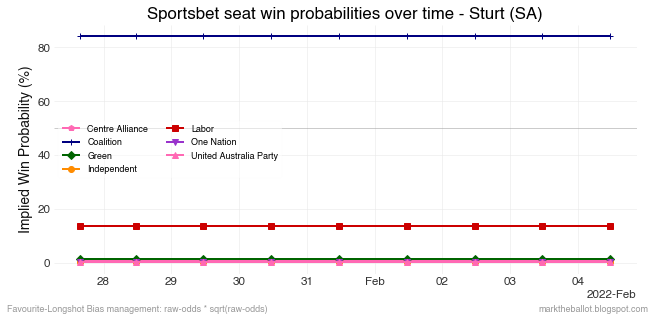

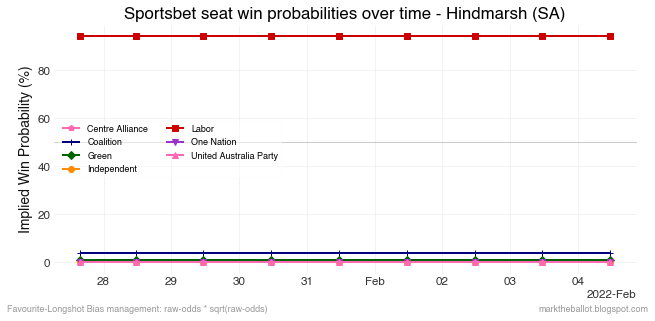

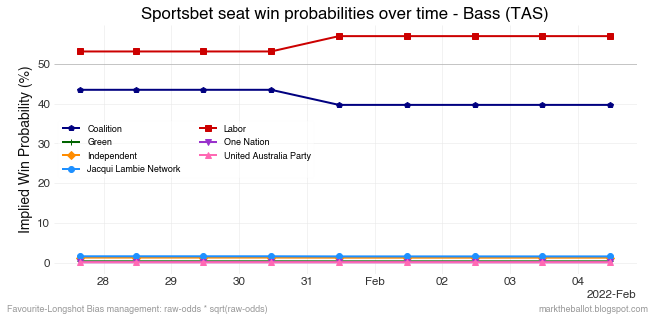

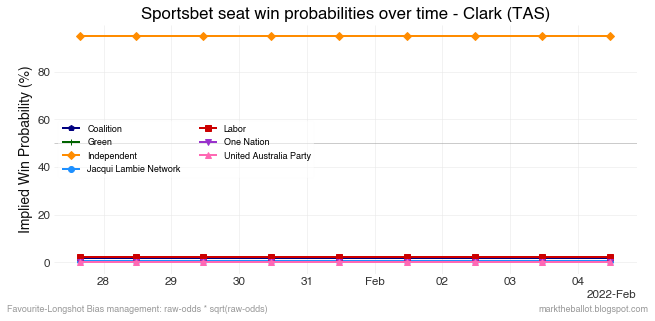

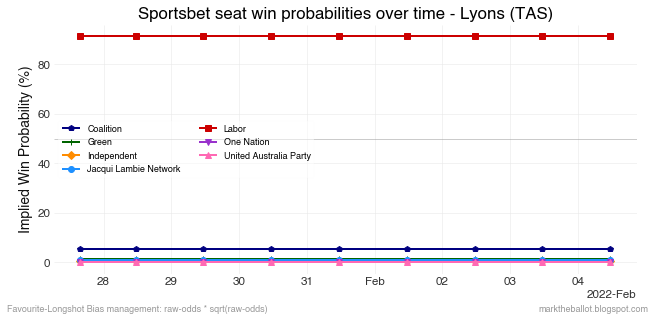

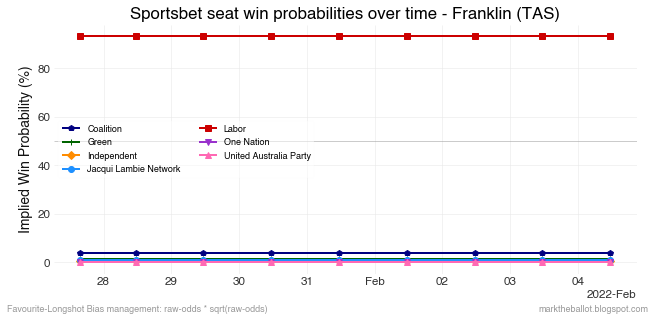

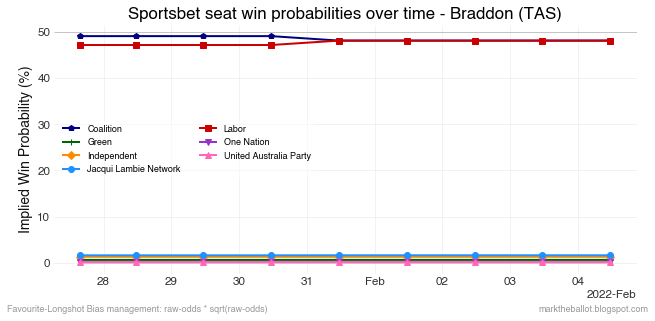

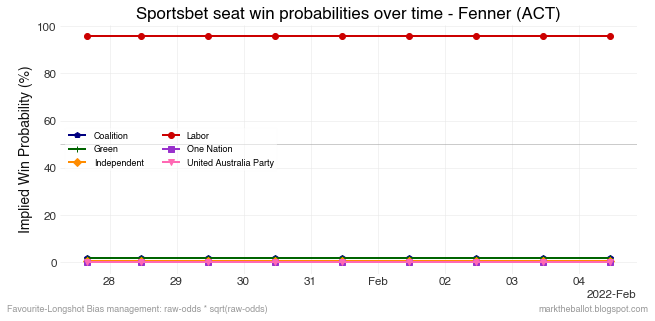

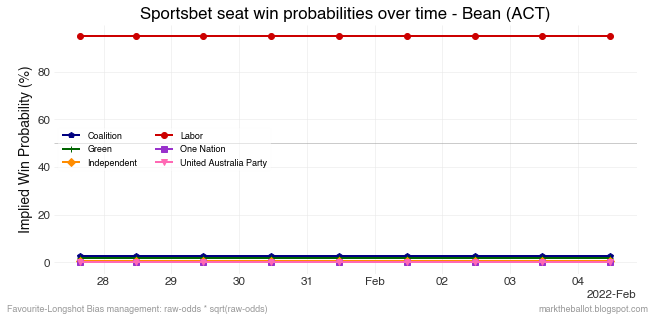

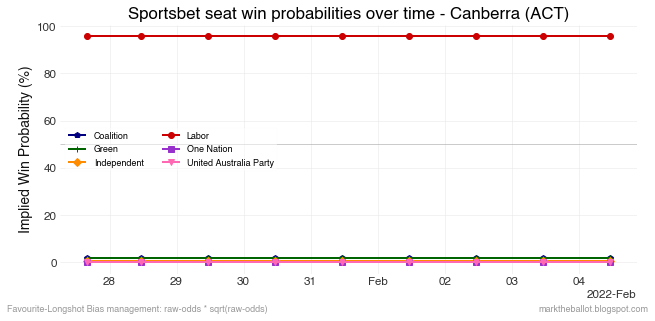

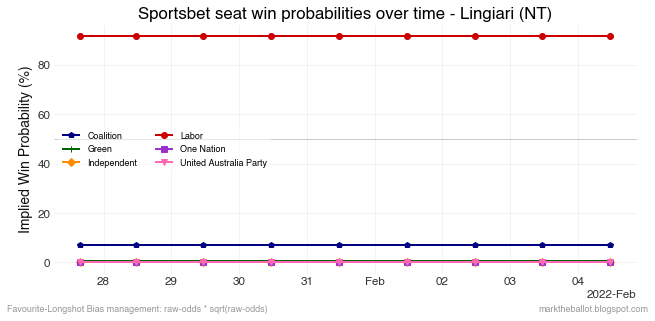

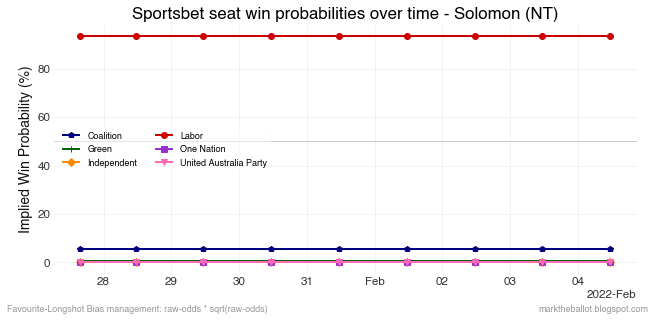

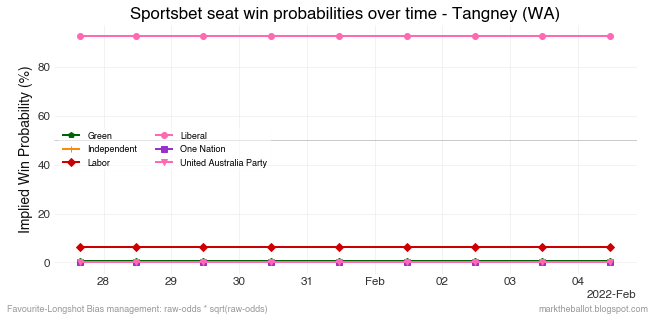

In [7]:
# produce plots
best_dict = {}
green_dict = {}
other_dict = {}
for seat in df.seat.unique():
    best_dict[seat], green_dict[seat], other_dict[seat] = plot_seat(df, seat)

### Seats that look like a close contest

In [8]:
# identiy the close contest seats
best_series = pd.Series(best_dict).sort_values(ascending=True)
best_series[best_series <= 60]#.index

Flinders (VIC)     47.770285
Braddon (TAS)      48.108806
Flynn (QLD)        49.677369
Deakin (VIC)       49.776531
Gilmore (NSW)      49.971559
Casey (VIC)        50.902564
Robertson (NSW)    50.971381
Longman (QLD)      51.328358
La Trobe (VIC)     51.385517
Lindsay (NSW)      51.385517
Boothby (SA)       52.561672
Reid (NSW)         54.304483
Hunter (NSW)       56.232814
Bass (TAS)         56.940014
Hasluck (WA)       59.054622
Dobell (NSW)       59.054622
dtype: float64

In [9]:
# same list different format
best_series[best_series <= 60].index

Index(['Flinders (VIC)', 'Braddon (TAS)', 'Flynn (QLD)', 'Deakin (VIC)',
       'Gilmore (NSW)', 'Casey (VIC)', 'Robertson (NSW)', 'Longman (QLD)',
       'La Trobe (VIC)', 'Lindsay (NSW)', 'Boothby (SA)', 'Reid (NSW)',
       'Hunter (NSW)', 'Bass (TAS)', 'Hasluck (WA)', 'Dobell (NSW)'],
      dtype='object')

### Seats where Greens most competitve

In [10]:
THRESHOLD = 10
green_series = pd.Series(green_dict).sort_values(ascending=False)
green_series[green_series >= THRESHOLD]

Melbourne (VIC)    96.629471
Higgins (VIC)      18.059841
Griffith (QLD)     11.495360
dtype: float64

### Seats where others are most competitive

In [11]:
other_series = pd.Series(other_dict).sort_values(ascending=False)
other_series[other_series >= THRESHOLD]

Kennedy (QLD)         97.010192
Clark (TAS)           95.579197
Warringah (NSW)       88.796336
Mayo (SA)             87.312094
Indi (VIC)            83.820068
Flinders (VIC)        48.031353
Wentworth (NSW)       33.606237
Goldstein (VIC)       30.846722
North Sydney (NSW)    18.828910
Curtin (WA)           17.754984
Kooyong (VIC)         12.512484
dtype: float64